# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**  
Данные находятся в файле `/datasets/autos.csv`.  
Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя  
 
 
Целевой признак
- `Price` — цена (евро)

## Импорт библиотек и подготовка окружения

In [11]:
!pip install tabulate
!pip install optuna
!pip install hyperopt
!pip install shap

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import timeit
import pickle
import shap

from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error,f1_score, roc_auc_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from lightgbm import LGBMClassifier, LGBMRegressor
from optuna.visualization.matplotlib import plot_param_importances

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

## Обзор данных

In [2]:
# Загрузим данные в переменную 'data' и посмотрим информацию.
data = pd.read_csv('/datasets/autos.csv')

display(data.shape)
display(data.info())
display(data.head())

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на количество пропусков в данных.

In [3]:
print('Количество пропусков в процентах от общего объема данных')
data.isna().sum()[lambda x: x > 0] / data.shape[0]

Количество пропусков в процентах от общего объема данных


VehicleType    0.105794
Gearbox        0.055967
Model          0.055606
FuelType       0.092827
NotRepaired    0.200791
dtype: float64

Проверим данные на наличие дубликатов.

In [4]:
print('Количество дубликатов:', data.duplicated().sum())
data[data.duplicated(keep=False)]

Количество дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


В данных содержится 4 дубликата. Их можно удалить.

### Резюме

1. Всего в данных содержится 354369 строк и 16 столбцов.  
2. 7 столбцов хранят данные в формате `int64`, 9 - в формате `object`.        

3. 5 столбцов содержат пропуски. Их количество указано ниже (в долях от общего объема данных):
- `VehicleType`: 0.11
- `Gearbox`: 0.06
- `Model`: 0.06
- `FuelType`: 0.09
- `NotRepaired`: 0.20  

Все столбцы, которые содержат пропуски - категориальные.  

4. В данных содержится 4 дубликата


## Краткий исследовательский анализ

Посмотрим на первые 5 строк датасета.

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на описание данных.

In [6]:
data.describe(percentiles=[.12, .25, .5, .75, .999])

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
12%,550.000000,1996.000000,43.000000,70000.000000,1.000000,0.0,18059.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
99.9%,19999.000000,2018.000000,700.000000,150000.000000,12.000000,0.0,99897.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Создадим несколько функций для удобства исследования данных.

In [7]:
# Фунцкция выводит список уникальных значений категориального столбца и их количество.
def print_unique_values(column):
    print(f'Уникальные значения {column}:')
    display(sorted(list(data.dropna()[column].unique())))
    display(data[column].value_counts(dropna=False))
    print(f'Contains {data[column].isna().sum()} NaN values')

Изучим каждый столбец по отдельности.

### Столбец `DateCrawled`

In [8]:
pd.to_datetime(data.DateCrawled).describe()

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Итак, мы выяснили, что скачивание анкет производилось с 5 марта 2016 года по 7 апреля 2016 года.

### Столбец `Price`

In [9]:
data.Price.describe(percentiles=[.05, .1, .25, .95])

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
5%          200.000000
10%         499.000000
25%        1050.000000
50%        2700.000000
95%       14600.000000
max       20000.000000
Name: Price, dtype: float64

5% объектов имеют стоимость ниже 200 евро.  

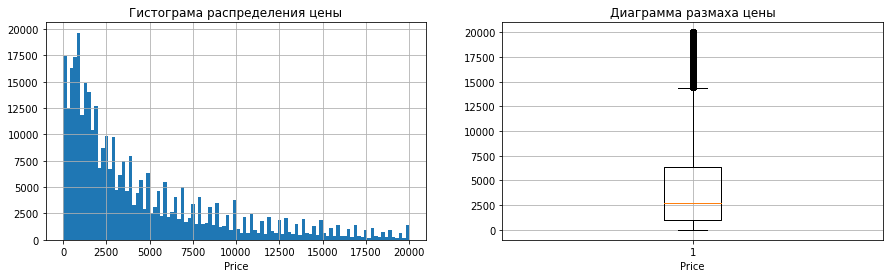

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(data.Price, bins=100);
ax[0].grid();
ax[0].set_xlabel('Price')
ax[0].set_title('Гистограма распределения цены')

ax[1].boxplot(data.Price)
ax[1].set_xlabel('Price')
ax[1].grid();
ax[1].set_title('Диаграмма размаха цены');

Есть нулевые и близкие к нулю значения. Посмотрим на их количество.

In [12]:
print('Количество объектов с ценой 0')
data.Price[lambda x: x == 0].count()

Количество объектов с ценой 0


10772

In [13]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 50), (51, 100), (101, 499), (500, 20000)], closed='both')
pd.cut(data.Price, bins).value_counts().sort_index()

[0, 10]          12112
[11, 50]           638
[51, 100]         1595
[101, 499]       21709
[500, 20000]    318315
Name: Price, dtype: int64

В данных содержатся 12750 автомобилей с ценой от 0 до 50 евро, и 1595 авто с ценой от 51 до 100 евро.

На основании почтовых индексов, которые содержатся в данных, можно предположить, что эти данные об автомобилях из Германии. По началу, суммы в 10 и 50 евро казались ошибочными, однако как оказалось, на рынке б/у автомобилей Германии действительно есть такие авто.

**Резюме**  
Оставим все как есть.

### Столбец `VehicleType`

Посмотрим на уникальные значения столбца `VehicleType`

In [14]:
print_unique_values('VehicleType')

Уникальные значения VehicleType:


['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Contains 37490 NaN values


Посмотрим на среднюю и медианную цену для каждого типа транспорта.

In [15]:
data.groupby('VehicleType', dropna=False)['Price'].agg(['mean', 'median']).round(1).sort_values(by='median')

,mean,median
VehicleType,,
NaN,2375.4,1199
small,2677.7,1500
other,3563.8,2200
sedan,4722.7,2999
wagon,4880.3,3200
coupe,6010.9,3950
bus,5487.1,4200
convertible,6807.0,5500
suv,9009.2,8500


**Резюме**  
Медианная цена для каждого VehicleType заметно отличается. Вероятно, что между этими переменными есть зависимость.  

'NaN' можно переименовать в 'unknown'

### Столбец `RegistrationYear`

In [16]:
data.RegistrationYear.describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [17]:
print('Уникальные значения RegistrationYear:')
display(sorted(list(data.RegistrationYear.unique())))

Уникальные значения RegistrationYear:


[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [18]:
bins = pd.IntervalIndex.from_tuples([(1000, 1800), (1801, 1900), (1901, 1950), (1951, 2000), (2001, 2016), (2017, 9999)], closed='both')
pd.cut(data.RegistrationYear, bins).value_counts().sort_index()

[1000, 1800]        66
[1801, 1900]         0
[1901, 1950]       198
[1951, 2000]    126479
[2001, 2016]    213096
[2017, 9999]     14530
Name: RegistrationYear, dtype: int64

Присоеденим столбец с интревалами по годам и посмотрим на среднюю и медианную цену для каждого года.

,mean,median
RegistrationYear_interval,,
"[1000, 1800]",1442.878788,400.0
"[1801, 1900]",NaN,NaN
"[1901, 1950]",4294.702020,425.0
"[1951, 2000]",1800.777299,1000.0
"[2001, 2016]",6056.512825,4700.0
"[2017, 9999]",3152.201996,1900.0


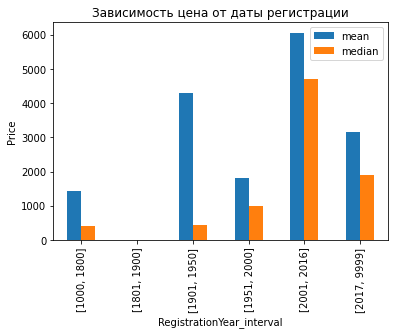

In [19]:
display(
    data.join(pd.cut(data.RegistrationYear, bins), rsuffix='_interval')
        .groupby('RegistrationYear_interval')['Price']
        .agg(['mean', 'median'])
)

(
    data.join(pd.cut(data.RegistrationYear, bins), rsuffix='_interval')
        .groupby('RegistrationYear_interval')['Price']
        .agg(['mean', 'median']).plot.bar()
) 

plt.ylabel('Price')
plt.title('Зависимость цена от даты регистрации');

В целом, если убрать из внимания два крайних интервала, то логика в ценообразовании присутствует. С 1901 по 1950 года могу присутсвовать раритетные автомобили, стоимость которых высока (из-за чего срендняя цена равна 4294 евро), однако судя по всему большинство авто в этом интервале устарели и медианная цена их равна 425 евро.  
Цена же с 1951 по 2000 года ниже, чем с 2001 по 2016, так как в последний интревал попадают более новые автомобили.

**Резюме**  
Данные об автомобилях, год регистрации которых попадает в интервалы [1000, 1800] и [2017, 9999] можно либо удалить, либо заменить значение года на 'NaN'.   
Также, следует создать признак "возраст авто", так как в разные моменты времени один и тот же год регистрации будет говорить о различном возрасте автомобиля, соответсвенно нам нужно использовать именно "возраст", а не "год регистрации".

### Столбец `Gearbox`

In [20]:
print_unique_values('Gearbox')

Уникальные значения Gearbox:


['auto', 'manual']

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

Contains 19833 NaN values


Посмотрим на среднюю и медианную цену для каждого типа коробки передач.

In [21]:
data.groupby('Gearbox', dropna=False)['Price'].agg(['mean', 'median']).round(1).sort_values(by='median')

,mean,median
Gearbox,,
NaN,2206.3,1000
manual,3980.8,2490
auto,6842.1,5500


Судя по всему автомобили с автоматической коробкой передач в среднем дороже, чем с ручной.

**Резюме**  
Вероятнее всего, корреляция между типом коробки передач и стоимостью авто присутвует.  
Отсутвующие значения можно заменить на категорию 'unknown'.

### Столбец `Power`

Подозрительно, что в столбце `Power` есть нулевые значения, а также значение в 20000. Посмотрим на них поближе.

In [22]:
print('Количество объектов с количеством лошадинных сил равными 0')
data.Power[lambda x: x == 0].count()

Количество объектов с количеством лошадинных сил равными 0


40225

In [23]:
data.Power.describe(percentiles=[.1, .25, .75, .95, .99, .999])

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
10%           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
95%         218.000000
99%         300.000000
99.9%       700.000000
max       20000.000000
Name: Power, dtype: float64

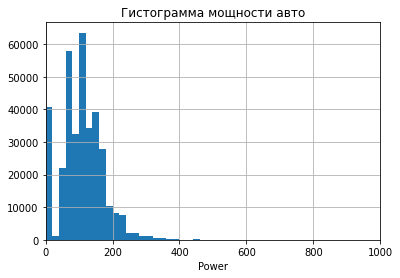

In [24]:
plt.hist(data.Power, bins=1000)
plt.grid()
plt.xlim(0, 1000)
plt.xlabel('Power')
plt.title('Гистограмма мощности авто');

Посмотрим на описание авто с мощностью равной нулю.

In [25]:
data[data.Power == 0].describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,40225,40225.000000,25597,40225.000000,26916,40225.0,33931,40225.000000,40225.000000,28564,40225,18810,40225,40225.0,40225.000000,40225
unique,38924,NaN,8,NaN,2,NaN,247,NaN,NaN,7,40,2,62,NaN,NaN,34697
top,2016-03-25 22:45:06,NaN,small,NaN,manual,NaN,other,NaN,NaN,petrol,volkswagen,no,2016-03-21 00:00:00,NaN,NaN,2016-04-07 09:45:10
freq,3,NaN,8309,NaN,22138,NaN,3169,NaN,NaN,19974,8191,14034,1509,NaN,NaN,6
mean,NaN,2171.864562,NaN,2010.061778,NaN,0.0,NaN,126035.922933,4.002809,NaN,NaN,NaN,NaN,0.0,46500.854941,NaN
std,NaN,3045.863549,NaN,248.317299,NaN,0.0,NaN,45350.959241,4.112125,NaN,NaN,NaN,NaN,0.0,25330.409996,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.0,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,400.000000,NaN,1998.000000,NaN,0.0,NaN,125000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,26607.000000,NaN
50%,NaN,1050.000000,NaN,2001.000000,NaN,0.0,NaN,150000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,45473.000000,NaN
75%,NaN,2600.000000,NaN,2007.000000,NaN,0.0,NaN,150000.000000,7.000000,NaN,NaN,NaN,NaN,0.0,65428.000000,NaN


Поделим мощность на интервалы и посмотрим сколько авто в ходит в каждый интервал.

In [26]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 43), (51, 700), (701, 20000)], closed='both')
pd.cut(data.Power, bins, duplicates='drop').value_counts().sort_index()

[0, 10]          40460
[11, 43]          2122
[51, 700]       303216
[701, 20000]       354
Name: Power, dtype: int64

Всего 354 из 354369 содержат значения свыше 700 лошадинных сил. Очень похоже, что это опечатка.

Посмотрим на график разброса цены и количества лошадинных сил.

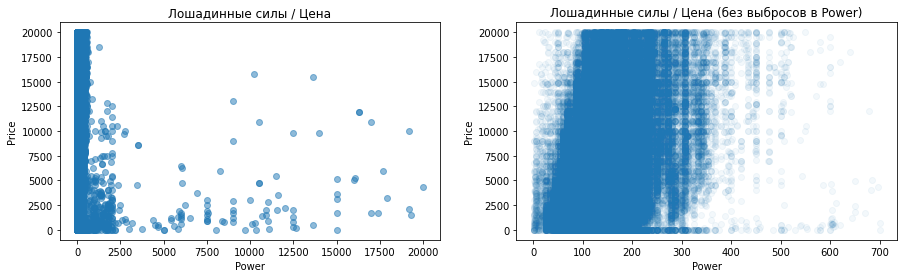

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].scatter(data.Power, data.Price, alpha=0.5);
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Price');
ax[0].set_title('Лошадинные силы / Цена');

ax[1].scatter(data[(data.Power < 701) & (data.Power != 0)].Power, data[(data.Power < 701) & (data.Power != 0)].Price, alpha=0.05);
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Price');
ax[1].set_title('Лошадинные силы / Цена (без выбросов в Power)');

In [28]:
print('Коэффициент корреляции (с выбросами в столбце Power)', data.Power.corr(data.Price).round(2))
print('Коэффициент корреляции (без выбросов в столбце Power)', data[(data.Power < 701) & (data.Power != 0)].Power.corr(data[data.Power < 701].Price).round(2))

Коэффициент корреляции (с выбросами в столбце Power) 0.16
Коэффициент корреляции (без выбросов в столбце Power) 0.49


Возможно, если мы удалим объекты со значениями Power > 700 и равные нулю, мы сможем улучшить точность нашей модели.

**Резюме**  
В данном столбце можно удалить аномально высокие значения, а также аномально низкие значения, либо объекты целиком, которые таковые содержат.

### Столбец `Model`

In [29]:
data.Model.nunique()

250

In [30]:
print_unique_values('Model')

Уникальные значения Model:


['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64

Contains 19705 NaN values


Есть 2 неявных дубликата: 'range_rover и 'rangerover',

**Резюме**  
Есть 2 неявных дубликата: 'range_rover и 'rangerover'. На этапе предобработки данных приведем их к виду 'range_rover'

### Столбец `Kilometer`

In [31]:
data.Kilometer.describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [32]:
data.Kilometer.nunique()

13

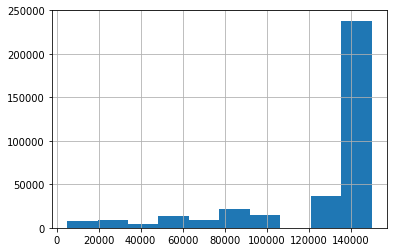

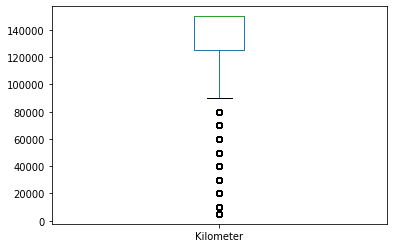

In [33]:
data.Kilometer.hist(bins=10)
plt.show()
data.Kilometer.plot(kind='box');

У нас всего 13 уникальных значений пробега. Мы можем проанализировать этот признак как категориальный. Посмотрим на среднюю стоимость автомобиля для каждого значения пробега.

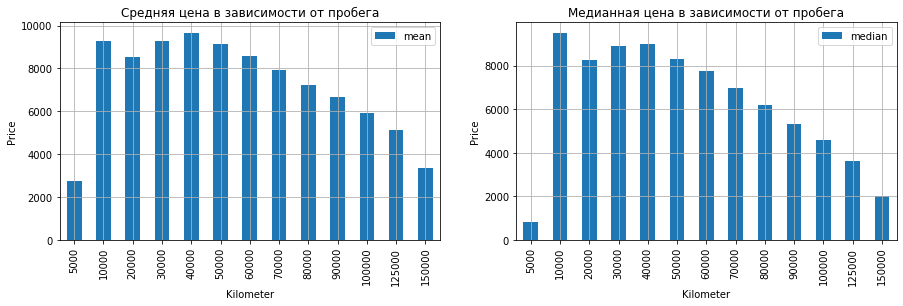

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

data.groupby('Kilometer')['Price'].agg(['mean']).plot.bar(ax=ax[0])
ax[0].set_xlabel('Kilometer')
ax[0].set_ylabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от пробега');

data.groupby('Kilometer')['Price'].agg(['median']).plot.bar(ax=ax[1])
ax[1].set_xlabel('Kilometer')
ax[1].set_ylabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от пробега');

В целом картина логична - чем выше пробег, тем ниже средняя цена на авто. Удивляет лишь то, что авто с пробегом 5000 км стоят так дешево. Видимо причина в чем-то ином. Можно предположить, что они битые, либо у них есть еще какие-либо неполадки, из-за чего их выставили на продажу с таким небольшим пробегом и такой, относительно низкой ценой. Но это лишь предположение.

**Резюме**  
С этим столбцом все ок.

### Столбец `RegistrationMonth`

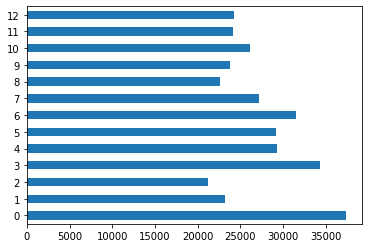

In [36]:
# Посмотрим на количество уникальных значений каждого номера месяца.
data.RegistrationMonth.value_counts().sort_index().plot.barh();

Не совсем понятно, почему всего 13 уникальных значений, а не 12 (разве что летоисчесление велось по лунно-солнечному еврейскому календарю, в котором переодически добавляется 13-й високосный месяц :)  
Однако, конечно, наиболее вероятно, что 0 - это незаполненное значение.  
Так или иначе мы не будем использовать этот столбец в качестве признака, поэтому не будем уделять ему много внимания и пойдем дальше.

### Столбец `FuelType`

In [36]:
print_unique_values('FuelType')

Уникальные значения FuelType:


['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Contains 32895 NaN values


Посмотрим на среднюю ценю для авто на каждом из видов топливной системы.

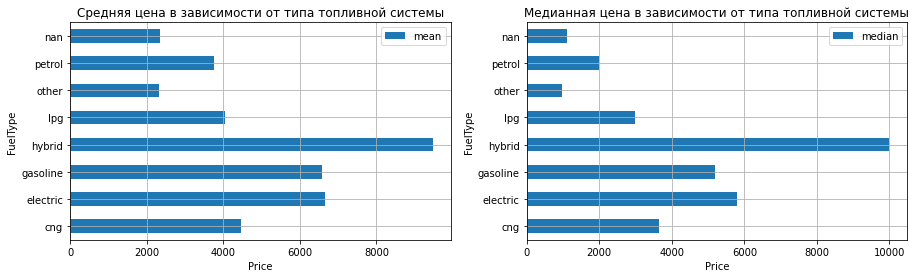

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

data.groupby('FuelType', dropna=False)['Price'].agg(['mean']).plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от типа топливной системы');

data.groupby('FuelType', dropna=False)['Price'].agg(['median']).plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от типа топливной системы');

Исходя их графиков можно предположить, что цена на автомобиль в определенной степени зависит от типа топливной системы.

Можно также заметить, что 'petrol' и 'gasoline' - это британское и американское название бензина. Однако, не смотря на то, что это синонимы - средняя цена у данных видов топлива различается значительно.

Может быть у различных марок авто указана различная топливная система, в зависимости от страны производителя?

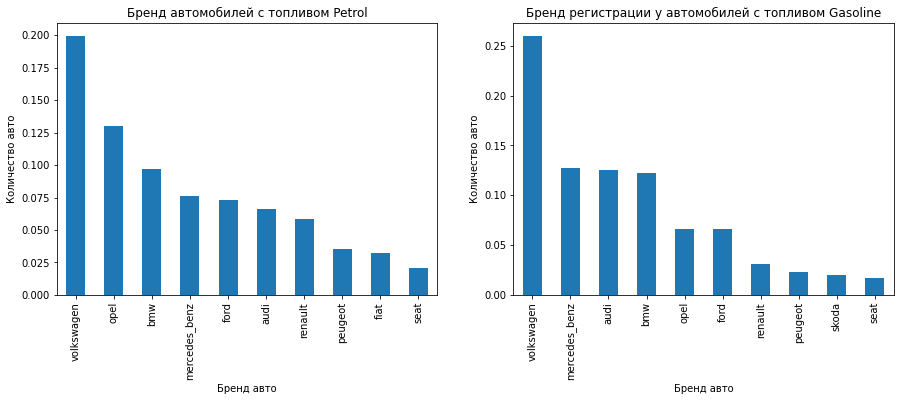

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

data[data['FuelType'] == 'petrol'].Brand.value_counts(normalize=True)[:10].plot.bar(title='Бренд автомобилей с топливом Petrol', ax=ax[0], ylabel='Количество авто', xlabel='Бренд авто')
data[data['FuelType'] == 'gasoline'].Brand.value_counts(normalize=True)[:10].plot.bar(title='Бренд регистрации у автомобилей с топливом Gasoline', ax=ax[1], ylabel='Количество авто', xlabel='Бренд авто');

Разницы практически нет. И там и там в топе немецкие авто.

Посмотрим на распределение года регистрации у автомобилей с 'petrol' и 'gasoline' видами топлива. Может быть название как-то связано с возрастом авто.

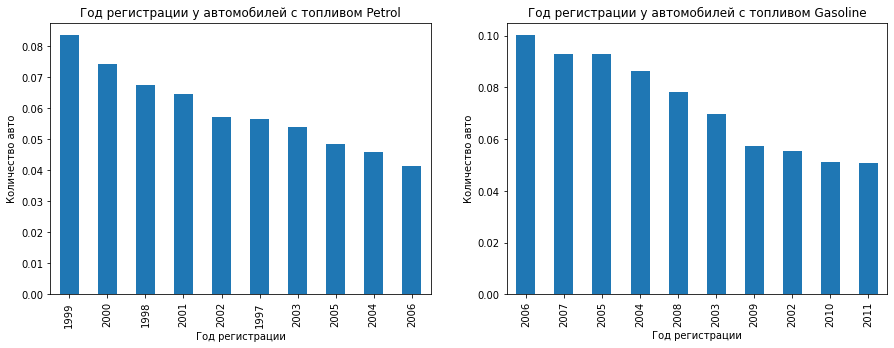

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

data[data['FuelType'] == 'petrol'].RegistrationYear.value_counts(normalize=True)[:10].plot.bar(title='Год регистрации у автомобилей с топливом Petrol', ax=ax[0], ylabel='Количество авто', xlabel='Год регистрации')
data[data['FuelType'] == 'gasoline'].RegistrationYear.value_counts(normalize=True)[:10].plot.bar(title='Год регистрации у автомобилей с топливом Gasoline', ax=ax[1], ylabel='Количество авто', xlabel='Год регистрации');

Похоже, что у более старых авто бензин называется 'petrol', в то время как у более новых авто он называется 'gasoline'. Может быть отсюда и разница в цене.   
Однако, так или иначе - нужно будет привести эти синонимы к единому значению.

**Резюме**  
В данной столбце есть 32895 пропусков. Их можно заполнить либо категорией 'unknown', либо использовать алгоритм машинного обучения (типа KNN), либо сгруппировать по определенным признакам и заполнить пропуски значениями, которые характерны для максимально похожих объектов (например на основании модели автомобиля, мощности и тд.).  
Также, стоит избавиться от неявных дубликатов в виде 'petrol' и 'gasoline'.

### Столбец `Brand`

In [40]:
print_unique_values('Brand')

Уникальные значения Brand:


['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Contains 0 NaN values


Посмотрим на среднюю цену авто для каждой модели.

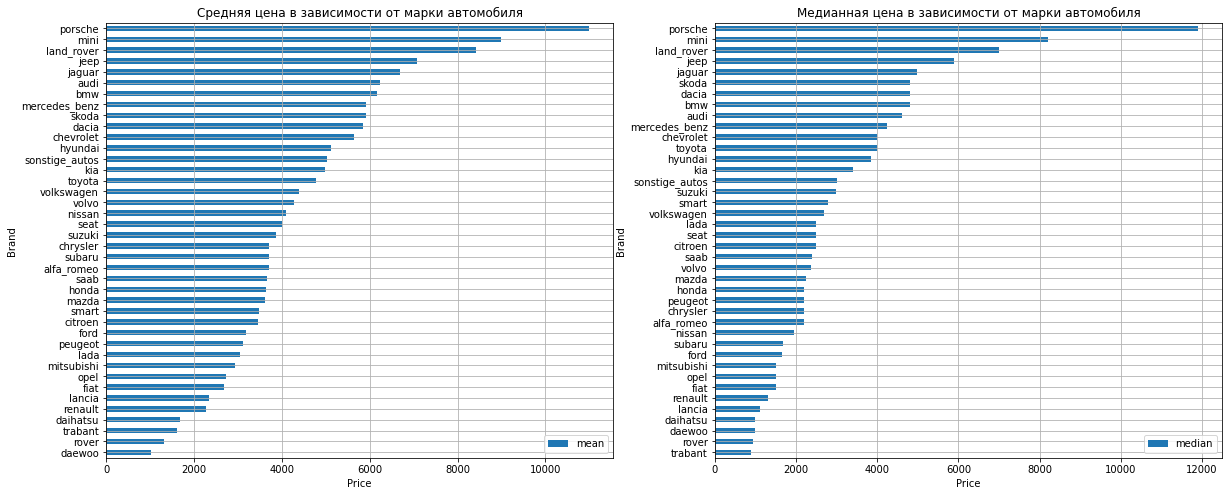

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

data.groupby('Brand')['Price'].agg(['mean']).sort_values(by='mean').plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от марки автомобиля');

data.groupby('Brand')['Price'].agg(['median']).sort_values(by='median').plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от марки автомобиля');

Очевидно, что марка автомобиля действительно влияет на его стоимость :)

**Резюме**  
С данным стобцом все в порядке. Оставляем как есть.

### Столбец `NotRepaired`

In [42]:
print_unique_values('NotRepaired')

Уникальные значения NotRepaired:


['no', 'yes']

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Contains 71154 NaN values


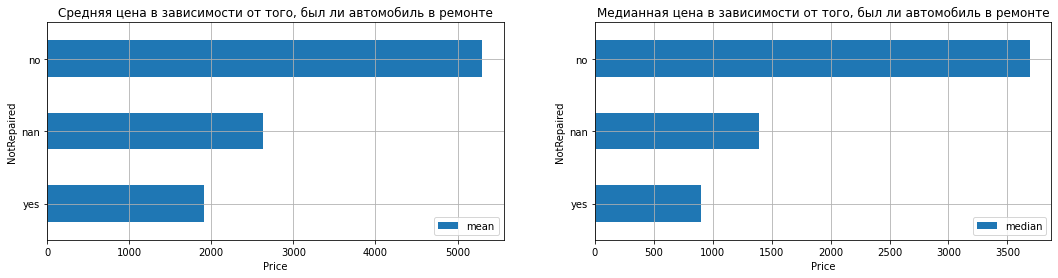

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

data.groupby('NotRepaired', dropna=False)['Price'].agg(['mean']).sort_values(by='mean').plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от того, был ли автомобиль в ремонте');

data.groupby('NotRepaired', dropna=False)['Price'].agg(['median']).sort_values(by='median').plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от того, был ли автомобиль в ремонте');

Изначально, название столбца `NotRepaired`, т.е. "Не починенный" наводило на мысль, что "yes" - значило "да, ни разу не побывавший в ремонте", а столбец "no" - означало "нет, побывавший в ремонте".  
Однако у автомобилей в категорией "no" средняя цена выше. Логично было бы предположить, что дороже будут стоить автомобили, которые ни разу не побывали в ремонте. Следовательно есть основания предполагать, что трактовка значений следующая:  
- "yes": "был в ремонте"
- "no": "не был в ремонте"

**Резюме**  
В данных есть пропуски. В худшем лучае их можно будет заменить на "unknown". И,хотя конечный пользователь нашего приложения скорее всего будет знать был ли его автомобиль в ремонте или нет, и, вероятно, при попытке предсказать цену своего авто такую категорию не укажет, это все же лучше чем удалять более 76000 строк из датасета. В лучшем случае, можно попробовать подобрать признаки, которые коррелируют как-то с этим столбцом и заполним пропуски на их основании.

### Столбец `DateCreated`

In [44]:
pd.to_datetime(data.DateCreated).describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

Анкеты были созданы в период с 3 октября 2014 года по 7 апреля 2016.

**Резюме**  
Данный признак не будет использован в ходе обучения модели.

### Столбец `NumberOfPictures`

In [45]:
print_unique_values('NumberOfPictures')

Уникальные значения NumberOfPictures:


[0]

0    354369
Name: NumberOfPictures, dtype: int64

Contains 0 NaN values


Удивительно, что все выгруженные объвления - без фотографий. Возможно, ошибка выгрузки.

**Резюме**  
Данный признак не будет использован в ходе обучения модели.

### Столбец `PostalCode`

In [46]:
data.PostalCode.describe()

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

Похоже, что это почтовый индексы Германии.

**Резюме**  
Данный признак не будет использован в ходе обучения модели.

### Столбец `LastSeen`

In [47]:
pd.to_datetime(data.LastSeen).describe()

count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Последняя активность пользователей находится в промежутке с 5 марта 2016 года по 7 апреля 2016 года.

### Корреляция

Посмотрим на коэффициент корреляции Пирсона. При этом отсечем объекты с выбросами в столбце `Power`

In [48]:
data[(data.Power < 701) & (data.Power != 0)].corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.083463,0.494105,-0.377636,0.078205,NaN,0.068111
RegistrationYear,0.083463,1.000000,0.023492,-0.069449,-0.000640,NaN,0.002738
Power,0.494105,0.023492,1.000000,0.100031,0.045085,NaN,0.055642
Kilometer,-0.377636,-0.069449,0.100031,1.000000,-0.014861,NaN,-0.010982
RegistrationMonth,0.078205,-0.000640,0.045085,-0.014861,1.000000,NaN,0.005847
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.068111,0.002738,0.055642,-0.010982,0.005847,NaN,1.000000


Есть небольшая линейная корреляция цены с мощностью (прямая) и пробегом (обратная).

### Резюме

В результате краткого ислледовательского анализа данных, было выявлено, что:  
- Средняя цена на авто варьируется в зависимости от типа кузова.
- Средняя цена на авто зависит от даты регистрации. Чем старше автомобиль тем ниже его медианная цена.  
- Средняя цена на авто варьируется в зависимости от типа коробки передач. 
- Есть прямая линейная зависимость средней силы между мощностью и ценой.  
- Средняя цена на авто зависит от пробега. В общем случае - чем выше пробег, тем ниже стоимость.  
- Средняя цена на авто варьируется в зависимости от типа топливной системы  
- Средняя цена на авто варьируется в зависимости от модели  
- На среднюю цену влияет факт того, было ли авто в ремонте.

## Подготовка данных

- Удалим дубликаты
- Удалим следующие столбцы: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`,  `PostalCode`,  `LastSeen`  
- Обработаем неявные дубликаты ('range_rover и 'rangerover') в `Model`, и 'petrol'/'gasoline' в столбце `FuelType`.  
- Создадим признак "возраст авто" на основании года регистрации и года выгрузки (год выгрузки - 2016г)  

Далее, в качестве эксперимента:  
- Избавимся от аномальных значений в столбцах `Power` (Power > 700) и `RegistrationYear`  [1000, 1800] и [2017, 9999]   

Затем:
- Определим способ заполнения пропусков в столбцах: `VehicleType`, `Gearbox`,  `FuelType`, `NotRepaired`, `Model`  

In [3]:
# Удалим дубликаты и лишние столбцы
data_pp = data.drop_duplicates().drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

# Избавимся от неявных дубликатов в столбце 'Model' и 'FuelType'
data_pp['Model'] = data_pp['Model'].mask(data_pp['Model'] == 'rangerover', other='range_rover')
data_pp['FuelType'] = data_pp['FuelType'].mask(data_pp['FuelType'] == 'petrol', other='gasoline')

# Создадим признак 'AgeOfCar' и сохраним туда разность года выгрузки (2016) и года регистрации авто
data_pp['AgeOfCar'] = 2016 - data_pp['RegistrationYear']

# Удалим признак 'RegistrationYear'
data_pp = data_pp.drop('RegistrationYear', axis=1)

# Все значения возраста авто, которые меньше нуля либо больше 215 лет заменим на -10. 
# Мы сделаем это и для тренировочного и для тестового датасета, чтобы объеденить нереалистичные значения возраста воедино.
data_pp['AgeOfCar'] = data_pp['AgeOfCar'].where(data_pp.AgeOfCar.isin(range(0, 215)), -10)

In [4]:
# Посмотрим на получившийся датасет
data_pp.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,AgeOfCar
0,480,NaN,manual,0,golf,150000,gasoline,volkswagen,NaN,23
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,manual,75,golf,150000,gasoline,volkswagen,no,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8


Разделим данные на трейн и тест.  
В тренировочных данных попробуем обработать аномальные значения, и проверим, поможет ли нам такая предобработка улучшить качество модели.  

В тестовых данных в дальнейшем произведем лишь незначительные преобразования, такие как заполнения пропусков, кодирование, которое необходимо моделям для обучения.

В переменные `train_data_raw` и `test_data_raw` сохраним исходные данные. В переменную `train_data` будем сохранять преобразованные данные. 

In [4]:
train_data_raw, test_data_raw = train_test_split(data_pp, test_size=0.2, shuffle=True, random_state=777)
train_data, test_data = train_test_split(data_pp, test_size=0.2, shuffle=True, random_state=777)

for df in (train_data, test_data):
    print(df.shape)

(283492, 10)
(70873, 10)


In [5]:
# Сохраним названия и индексы категориальных столбцов в переменные 'cat_columns' и 'cat_columns_idx'
cat_columns = [
    col for col in train_data.drop('Price', axis=1).select_dtypes(include=['object']).columns
]
cat_columns_idx = [
    i for i, name in enumerate(train_data.drop('Price', axis=1).columns) 
    if name in train_data.drop('Price', axis=1).select_dtypes(include=['object'])
]

# Сохраним названия и индексы числовых столбцов в переменные 'num_columns' и 'num_columns_idx'
num_columns = [
    col for col in train_data.drop('Price', axis=1).select_dtypes(include=['integer', 'float']).columns
]
num_columns_idx = [
    i for i, name in enumerate(train_data.drop('Price', axis=1).columns) 
    if name in train_data.drop('Price', axis=1).select_dtypes(include=['integer', 'float'])
]

# Сохраним названия столбцов с пропущенными значениями в переменные 'num_columns' и 'num_columns_idx'
nan_columns = [
    col for col in train_data.drop('Price', axis=1).isna().sum()[train_data.drop('Price', axis=1).isna().sum() > 0].index
]

### Предобработаем аномальные значения

Заполним NaN-ами значения в столбце `Power` > 701, а также возраст авто (`AgeOfCar`), который меньше нуля (для автомобилей, у которых год регистрации, меньше 1801 и больше 2016 соотвественно мы задали значение -10). Затем, подумаем, как можно эти пропуски заполнить наиболее реалистичными значениями.

In [53]:
train_data['Power'] = train_data['Power'].where(train_data.Power.isin(range(1, 701)))
train_data['AgeOfCar'] = train_data['AgeOfCar'].where(train_data.AgeOfCar.isin(range(0, 215)))

А теперь попробуем заполнить эти пропуски новыми значениями.

#### `AgeOfCar`

In [54]:
(f'Пропусков в AgeOfCar: {(train_data.AgeOfCar.isna().sum() / train_data.shape[0]).round(2) * 100}%')

'Пропусков в AgeOfCar: 4.0%'

Посмотрим как зависит средний возраст автомобиля от пробега. Возраст будем считать на момент 2016 года, так как выгрузка была сделана именно в этом году.

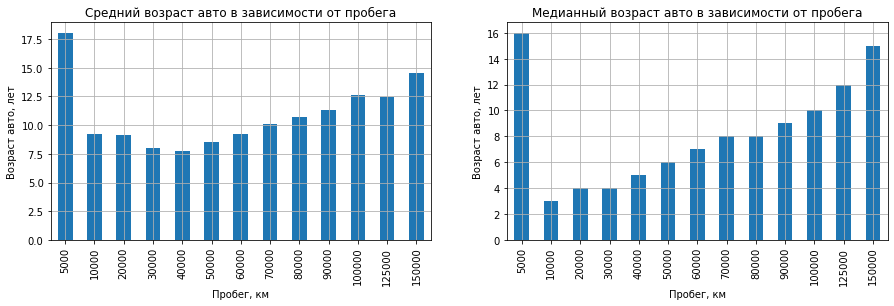

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

(train_data.groupby('Kilometer')['AgeOfCar'].mean().sort_index()).plot.bar(ax=ax[0]);
ax[0].set_title('Средний возраст авто в зависимости от пробега')

(train_data.groupby('Kilometer')['AgeOfCar'].median().sort_index()).plot.bar(ax=ax[1]);
ax[1].set_title('Медианный возраст авто в зависимости от пробега');

[
    (ax[i].grid(), 
     ax[i].set_xlabel('Пробег, км'), 
     ax[i].set_ylabel('Возраст авто, лет')) 
    for i in [0, 1]
];

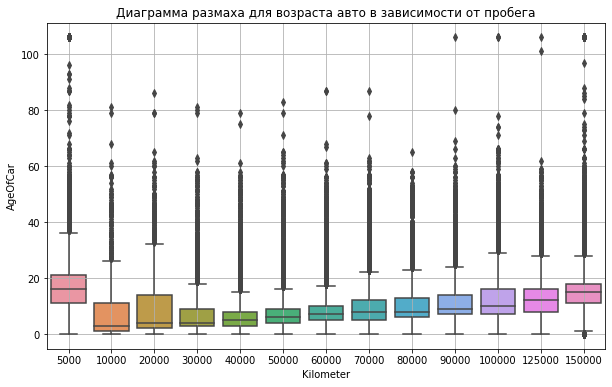

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x=train_data.Kilometer, y=(train_data.AgeOfCar));
ax.grid(which='both')
plt.title('Диаграмма размаха для возраста авто в зависимости от пробега');

Хорошо видно, что чем больше пробег - тем более давно автомобиль был зарегестрирован. Исключение составляют лишь автомобили с пробегом в 5000км.  
Таким образом, мы можем сгруппировать авто по пробегу, взять медианный возраст автомобиля и заполнить этим значением пропуски.

In [57]:
train_data['AgeOfCar'] = train_data['AgeOfCar'].fillna(train_data.groupby('Kilometer')['AgeOfCar'].transform('median'))

#### `Power`

In [58]:
(f'Пропусков в Power: {(train_data.Power.isna().sum() / train_data.shape[0]).round(3) * 100}%, {train_data.Power.isna().sum()}')

'Пропусков в Power: 11.5%, 32507'

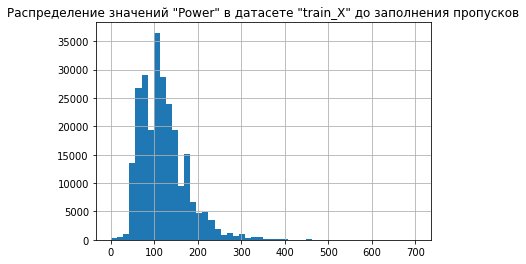

In [59]:
# Посмотрим на распределение значений признака 'Power' в датасете 'train_X'
plt.hist(train_data.Power, bins=50);
plt.grid()
plt.title('Распределение значений "Power" в датасете "train_X" до заполнения пропусков');

Гипотетически, мощность может зависеть от бренда, модели, типа топлива, типа транспорта и года выпуска авто.

In [60]:
# Сгруппируем по столбцам и заполним средним. Выведем на экран оставшееся количество пропусков.
train_data['Power'].fillna(train_data.groupby(['Brand', 'Model', 'VehicleType', 'FuelType', 'AgeOfCar'])['Power'].transform('mean')).isna().sum()

17256

Видно, что, если мы просто сгруппируем по данным столбцам и заполним средним, то у нас все еще останется более 21000 пропусков. Попробуем пойти иным путем.

На основании этих признаков предскажем мощность.

In [61]:
# Разделим тренировочную выборку на матрицу признаков X и вектор ответов y
X = train_data[['Brand', 'Model', 'VehicleType', 'FuelType', 'AgeOfCar']]
y = train_data['Power']

# Разделим данные на обучающую выборку и тест. В тесте будут содердаться объекты, для которых мы хотим заполнить пропуски
train_X, train_y = X[y.notna()], y[y.notna()]
test_X = X[y.isna()]

# Создадим Pipeline для модели Случайного Леса
pipe = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('transformer', ColumnTransformer(
            [('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=777), [0, 1, 2, 3])]
                                     , remainder='passthrough')
    ), 
    ('estimator', RandomForestRegressor(min_samples_leaf=5, max_features='sqrt', random_state=777))

])

# Создадим Pipeline для контсантной модели, которая будет предсказывать среднее значение целевого показателя
pipe_dummy = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('transformer', ColumnTransformer(
            [('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=777), [0, 1, 2, 3])]
                                     , remainder='passthrough')
    ), 
    ('estimator', DummyRegressor())

])

Проверим, насколько точно наша модель может предсказывать мощность автомобиля на основании имеющихся признаков.

In [62]:
score = cross_val_score(pipe, train_X, train_y, scoring='neg_root_mean_squared_error', cv=5,  error_score="raise")
score_dummy = cross_val_score(pipe_dummy, train_X, train_y, scoring='neg_root_mean_squared_error', cv=5,  error_score="raise")

print(f'RMSE модели: {-1*score.mean()}')
print(f'RMSE константной модели {-1*score_dummy.mean()}')

RMSE модели: 30.665387654588944
RMSE константной модели 54.07393907233459


Модель предсказывает мощность авто с погрешностью в среднем 30 лошадинные силы. При этом это ошибка на 20 единиц меньше, чем у константного алгоритма. Это неплохой результат.

Сделаем предсказания для пропущенных значений, и заполним этими значениями пропуски в нашем тренировочном датасете.

In [63]:
# Обучим модель на всех данных, для которых известна мощность
pipe.fit(train_X, train_y)

# Сделаем предсказание для объектов с пропущенными значениями 'Power'  и сораним предсказания в Series
filling_values = pipe.predict(test_X)
filling_values_series = pd.Series(filling_values, index=test_X.index)

# Заполним предсказанными значениями пропуски в столбце 'Power' в тренировочном датасете
train_data['Power'] = train_data['Power'].fillna(filling_values_series)

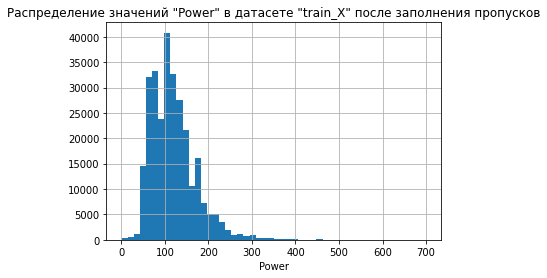

In [64]:
# Вновь посмотрим на распределение значений признака 'Power' в датасете 'train_X' (уже после заполнения)
plt.hist(train_data.Power, bins=50);
plt.grid()
plt.xlabel('Power')
plt.title('Распределение значений "Power" в датасете "train_X" после заполнения пропусков');

Форма распределения после заполнения пропусков сохранилась.

In [65]:
# Удалим лишние переменные
del X, y, train_X, train_y, test_X

---

### Решим, что делать с пропусками

Пропуски в предыдущих двух столбцых мы создали искуственно, и в тестовых данных пропусков в данных признаках мы не встретим.  
В следующих же 4-х столбцах пропуски могут также встретиться и тестовом наборе данных. Их мы будем заполнять индивидуально для каждой модели с использованием пайплайнов.

Проверим, совпадают ли столбцы с пропусками в обучающем и тестовом наборах данных.

In [66]:
print('Train data')
display(train_data.isna().sum()[train_data.isna().sum() > 0])
print('Test data')
display(test_data.isna().sum()[train_data.isna().sum() > 0])

Train data


VehicleType    30005
Gearbox        15796
Model          15770
FuelType       26312
NotRepaired    56884
dtype: int64

Test data


VehicleType     7485
Gearbox         4037
Model           3935
FuelType        6583
NotRepaired    14270
dtype: int64

Да, в тренировочном и тестовом наборе данных пропуски содержатся в одинаковых столбцах. Все столбцы, которые содердат пропуски - категориальные. В данных столбцах заменим на значение 'unknown', а для градиентного бустинга пропуски заполнять не будем.

-------------------

Теперь нужно проверить, на каких данных будет работать лучше модель. Для примера возмем градиентный бустинг, так как это будет оснвная модель, с которой мы будем работать в данном проекте. Измерим качество его работы с помощью кросс-валидации на исходной выборке и на выборке с преобразованными аномальными значениями. 

In [67]:
# Создадим функцию, которая будет проверять работу градиентного бустинга на данных, с использованием кросс-валидации.
def check_rmse_on_data(data, data_title, categorical_columns=cat_columns):
    # Разделим данные на X и y
    X, y = data.drop('Price', axis=1), data['Price']
    
    # Преобразуем категориальные стобцы к нужному формату
    X[cat_columns] = X[cat_columns].astype('category')
    
    # Инициализируем модель LGBMRegressor
    estimator = LGBMRegressor(random_state=777)
    
    # Сохраним результаты 5-fold кросс-валидации в переменной 'scores'
    scores = cross_val_score(
        estimator, X, y, scoring='neg_root_mean_squared_error',error_score="raise", 
        fit_params={'categorical_feature': categorical_columns}
    )
    
    return round(-1 * scores.mean(), 2)

In [68]:
for name, data in zip(['Данные с преобразованными аномальными значениями', 'Данные с исходными значениями'], 
                      [train_data, train_data_raw]):
    score = check_rmse_on_data(data, name)
    print(f'{name}: RMSE = {score}')

Данные с преобразованными аномальными значениями: RMSE = 1800.51
Данные с исходными значениями: RMSE = 1794.51


Похоже, что модель выдает более качественнный результат на данных, в которых аномальные занчения столбцов `AgeOfCar` и `Power` не подвергались преобразованиям.  
Значит, для дальнейшей работы будем использовать исходные данные, которые хранятся в переменных `train_data_raw`, `test_data_raw`.     

P.S.  
Если бы мы брали за основу линейные модели, то преобразование было бы безуловно необходимым.

### Резюме

На данном этапе мы подготовили датасет для машинного обучения, а именно:  
- Удалили дубликаты и лишние столбцы (`DateCrawled`, `RegistrationMonth`, `RegistrationYear`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`)
- Избавились от неявных дубликатов в столбцах 'Model' и 'FuelType'
- Создали признак `AgeOfCar` и сохранили туда разность года выгрузки (2016) и года регистрации авто
- Все значения возраста авто, которые меньше нуля либо больше 215 лет заменили на -10 (для тренировочного и тестового датасета).  

Также мы провели эксперимент с предобработкой аномальных значений в столбцах `AgeOfCar` и `Power`, проверили качество градиентного бустинга на таком датасете и приняли решения оставить аномальные значения в данных столбцах без предобработки, так как rmse модели оказалось хуже, чем rmse модели на исходных данных.  
Также было решено заполнять пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` значениями "unknown" с использованием пайплайнов индивидуально для каждой модели.

## Обучение моделей

Для начала подготовим данные для обучения.

In [6]:
# Разделим тренировочные и тестовые данные на X и y
train_X, train_y = train_data_raw.drop('Price', axis=1), train_data_raw['Price']
test_X, test_y = test_data.drop('Price', axis=1), test_data['Price']

# Преобразуем столбцы формата 'object' в формат 'category'
train_X[cat_columns] = train_X[cat_columns].astype('category')
test_X[cat_columns] = test_X[cat_columns].astype('category')

# И числовые столбцы преобразуем к минимально возможному формату 'integer'
for col in num_columns:
    train_X[col] = pd.to_numeric(train_X[col].astype('int'), downcast='integer')
    test_X[col] = pd.to_numeric(test_X[col], downcast='integer')

train_y = pd.to_numeric(train_y, downcast='integer')
test_y = pd.to_numeric(test_y, downcast='integer')

In [7]:
# Выведем на экран размеры получившихся выборок
for name, data_X, data_y in [('Shape of train\n X \t\t y', train_X, train_y), ('Shape of test\n X \t\t y', test_X, test_y)]:
    print(name)
    print(data_X.shape, data_y.shape)
    print('-'*10)
    
# Выведем на экран форматы хранения данных
for name, types in zip(['Types of: Train X', 'Types of: Test X'], [train_X.dtypes, test_X.dtypes]):
    print(name)
    print(types)
    print('-'*10)

Shape of train
 X 		 y
(283492, 9) (283492,)
----------
Shape of test
 X 		 y
(70873, 9) (70873,)
----------
Types of: Train X
VehicleType    category
Gearbox        category
Power             int16
Model          category
Kilometer         int32
FuelType       category
Brand          category
NotRepaired    category
AgeOfCar           int8
dtype: object
----------
Types of: Test X
VehicleType    category
Gearbox        category
Power             int16
Model          category
Kilometer         int32
FuelType       category
Brand          category
NotRepaired    category
AgeOfCar           int8
dtype: object
----------


Формат успешно изменен.

Проверим несколько простых моделей с базовыми настройками и сохраним результаты их работы (метрику качества, скорость обучения и предсказания) в таблицу.  
 
 
Оценивать качество работы алгоритма будем с помощью 5-fold кросс-валидации.

In [8]:
# Создадим таблицу, в которую будем сохранять результаты
results_table = pd.DataFrame(index=['RMSE, eur', 'Fit time, sec', 'Predict time, sec'])

# Создадим функцию, которая будет измерять время обучения и предсказания модели.
def estimate_time(model, method, X, y=None, fit_params={}):
    if method == 'fit':
        start = timeit.default_timer()
        model.fit(X, y, **fit_params)
        stop = timeit.default_timer()

    elif method == 'predict':
        start = timeit.default_timer()
        model.predict(X)
        stop = timeit.default_timer()
        
    return round((stop - start), 2)

### Константный алгоритм

В качестве константного алгоритма возьмем модель, которая всегда предсказывает среднее значение целевого показателя на обучающей выборке.

In [72]:
# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_dummy'
score_dummy = cross_val_score(
    DummyRegressor(), train_X, train_y, scoring='neg_root_mean_squared_error',  error_score="raise"
)

print(f'Качество константного алгоритма: RMSE = {round(-1 * score_dummy.mean(), 2)}')

Качество константного алгоритма: RMSE = 4515.36


In [73]:
# Сохраним результаты в таблицу
results_table['Dummy'] = [-1 * round(score_dummy.mean(), 2), np.nan, np.nan]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN


### Linear Regression (Elastic-Net regularization)

In [74]:
# Инициализируем пайплайн
lr_pipe = Pipeline(
    [
        ('fill_na', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('ohe', ColumnTransformer(
            [
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_columns_idx)
            ],
                                remainder='passthrough')
        ), 
        ('scaling', StandardScaler(with_mean=False)),
        ('estimator', ElasticNet(random_state=777))
    ]
)

# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_lr'
score_lr = cross_val_score(
    lr_pipe, train_X, train_y, scoring='neg_root_mean_squared_error',  error_score="raise"
)

print(f'Качество линейной регрессии: RMSE = {round(-score_lr.mean(), 2)}')

Качество линейной регрессии: RMSE = 3141.18


In [76]:
# Сохраним результаты в таблицу
results_table['LinearRegression'] = [-1 * round(score_lr.mean(), 2), 
                                     estimate_time(lr_pipe, 'fit', train_X, train_y), 
                                     estimate_time(lr_pipe, 'predict', train_X.iloc[0].values.reshape(1, -1))]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN
LinearRegression,3141.18,4.63,0.0


### Random Forest Regression

In [77]:
# Инициализируем пайплайн
rf_pipe = Pipeline(
    [
        ('fill_na', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('ord_enc', ColumnTransformer(
            [
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=888), cat_columns_idx)
            ], 
                                remainder='passthrough')
    ), 
        ('estimator', RandomForestRegressor(min_samples_leaf=5, max_features='sqrt', random_state=777))
    ]
)

# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_rf'
score_rf = cross_val_score(
    rf_pipe, train_X, train_y, scoring='neg_root_mean_squared_error',  error_score="raise"
)

print(f'Качество случайного леса: RMSE = {round(-1 * score_rf.mean(), 2)}')

Качество случайного леса: RMSE = 1784.97


In [78]:
# Сохраним результаты в таблицу
results_table['RandomForest'] = [-1 * round(score_rf.mean(), 2), 
                                 estimate_time(rf_pipe, 'fit', train_X, train_y), 
                                 estimate_time(rf_pipe, 'predict', train_X.iloc[0].values.reshape(1, -1))]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN
LinearRegression,3141.18,4.63,0.00
RandomForest,1784.97,26.65,0.01


### Gradient Boosting

In [79]:
# Инициализируем модель градиентного бустинга
lgbm_regressor = LGBMRegressor(random_state=777)

Для начала проверим работу градиентного бустинга с заменой пропусков на 'unknown' и Ordinal-кодированием внутри пайплайна.

In [80]:
# Инициализируем пайплайн
lgbm_pipe = Pipeline(
    [
        ('fill_na', SimpleImputer(strategy='constant', fill_value='unknown')), 
        ('ord_enc', ColumnTransformer(
            [
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=777), cat_columns_idx)], 
                                remainder='passthrough')
        ),
        ('estimator', lgbm_regressor)
    ]
)

# Созраним параметры для обучения в переменной 'fit_params_pipe'
fit_params_pipe = {'estimator__feature_name': list(train_X.columns)}

# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_lgbm_pipe'
score_lgbm_pipe = cross_val_score(
    lgbm_pipe, train_X, train_y, scoring='neg_root_mean_squared_error', 
    error_score="raise", fit_params=fit_params_pipe
)
                   
print(f'Качество градиентного бустинга с замещением пропусков и Ordinal-кодированием признаков в пайплайне: RMSE = {round(-1 * score_lgbm_pipe.mean(), 2)}')

Качество градиентного бустинга с замещением пропусков и Ordinal-кодированием признаков в пайплайне: RMSE = 1868.07


Теперь оставим категориальные значение без кодирования, но также заполним пропуски значениями 'unknown'

In [81]:
# Подготовим датасет с заполнеными пропусками.
train_X_new = pd.DataFrame(
    SimpleImputer(strategy='constant', fill_value='unknown').fit_transform(train_X), 
    columns=train_X.columns
)

train_X_new[cat_columns] = train_X_new[cat_columns].astype('category')
train_X_new[num_columns] = train_X_new[num_columns].astype('int')

# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_lgbm_fillna'
score_lgbm_fillna = cross_val_score(
    lgbm_regressor, train_X_new, train_y, scoring='neg_root_mean_squared_error', error_score="raise", 
    fit_params={'categorical_feature': cat_columns}
)

print(f'Качество градиентного бустинга с замещением пропусков: RMSE = {round(-1 * score_lgbm_fillna.mean(), 2)}')

Качество градиентного бустинга с замещением пропусков: RMSE = 1792.16


А теперь используем градиентный бустинг в стандартной настройке. Позволим ему самому поработать с пропусками и категориальными значениями.

In [82]:
# Сохраним результаты 5-fold кросс-валиадции в переменной 'score_lgbm'
score_lgbm = cross_val_score(
    lgbm_regressor, train_X, train_y, scoring='neg_root_mean_squared_error', 
    error_score="raise", fit_params={'categorical_feature': cat_columns}
)

print(f'Качество градиентного бустинга: RMSE = {round(-1 * score_lgbm.mean(), 2)}')

Качество градиентного бустинга: RMSE = 1794.51


Наилучший результат LightGBM показал, когда мы заполнили пропущенные категориальные значения 'unknown' и оставили категориальные признаки без Ordinal-кодирования.   
Однако, предобработка данных в данном случае занимает некоторое время, а результат изменяется незначительно, поэтому в целях удобства и скорости обучения позволим градиентому бустингу самостоятельно работать с пропусками.

Последний результат сохраним в таблицу.

In [83]:
# Сохраним результаты в таблицу
results_table['LightGBM'] = [
    -1 * round(score_lgbm.mean(), 2), 
    estimate_time(lgbm_regressor, 'fit', train_X, train_y, fit_params={'categorical_feature': cat_columns}), 
    estimate_time(lgbm_regressor, 'predict', train_X.iloc[0:0+1])
]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN
LinearRegression,3141.18,4.63,0.00
RandomForest,1784.97,26.65,0.01
LightGBM,1794.51,7.00,0.01


### Резюме  

На данном этапе были проверены 3 модели: линейная регрессия, случайный лес и градиентный бустинг над решающими деревьями. Были получены следующие результаты:   

|                  |   RMSE, eur |   Fit time, sec |   Predict time, sec |
|:-----------------|------------:|----------------:|--------------------:|
| Dummy            |     4515.36 |          nan    |              nan    |
| LinearRegression |     3141.18 |            4.63 |                0    |
| RandomForest     |     1784.97 |           26.65 |                0.01 |
| LightGBM         |     1794.51 |            7    |                0.01 |
 

- Линейная регрессия имеет самые лучшие показатели по скорости обучения и предсказания (4.6 сек. и менее 0.01 сек.), однако наихудшие показатели по качеству предсказания (rmse = 3141 eur).  
- Случайный лес показал наилучшее качество на кроссвалидации (rmse = 1785 eur), однако имеет самое высокое время обучение среди всех трех моделей (26.7 сек.).
- Градиентный бустинг показал незначительно худшее качество по сравнению со случайным лесом (rmse = 1795 eur), однако по скорости обучения оказался лидером после линейной регрессии (7 сек.). По скорости предсказания на одном объекте показатели градиентного бустинга и случаного леса равны (0.01 сек.) При этом, преимуществом градиентного бустинга является тот факт, что он подразумевает минимум предобработки данных.

На следующем этапе возьмем градиентный бустинг и попробуем улучшить качество его предсказания за счет подбора гиперпараметров.  
Также подберем гиперпараметры для случайного леса и проверим какая из моделей покажет наилушие показатели на контрольной выборке.

## Подбор гиперпараметров

### Подбор гиперпараметров для градиентного бустинга

На данном этапе подберем гиперпараметры для алгоритма градиентного бустинга с использование библиотеки `optuna`.

Будем подбирать следующие гиперпараметры:  
- `n_estimators`: количество деревьев в ансамбле,
- `learning_rate`: темп обучения,
- `max_depth` - максимальную глубину базовых алгоритмов.

In [10]:
# Создадим функцию, которую будем оптимизировать
def objective(trial, X, y):
    # Зададим пространство поиска
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "random_state": 777
    }
    
    # Вычислим качество предсказания модели на 5-fold кросс-валидации.
    lgbm = LGBMRegressor(**params)
    scores = cross_val_score(
        lgbm, X, y, error_score='raise', scoring='neg_root_mean_squared_error', 
        n_jobs=-1, fit_params={'categorical_feature': cat_columns}
    )
    
    # Вычислим средний RMSE
    rmse = -scores.mean()

    return rmse

In [11]:
%%time

# Создадим объект 'study', которые будет заниматься минимизацией функции 'objective'
study = optuna.create_study(direction="minimize", study_name='LGBM Tuning Hyperparameters')

# Обернем 'objective' внутрь lambda-фнукции, чтобы передать ей доп параметры
func = lambda trial: objective(trial, train_X, train_y)

# Запустим процесс оптимизации с количеством итераций равным 50-и
study.optimize(func, n_trials=50, n_jobs=-1, show_progress_bar=True)

[I 2022-05-19 10:49:05,472] A new study created in memory with name: LGBM Tuning Hyperparameters
[I 2022-05-19 10:58:25,149] Trial 2 finished with value: 1820.0481787985882 and parameters: {'n_estimators': 700, 'learning_rate': 0.0681957231044937, 'max_depth': 3}. Best is trial 2 with value: 1820.0481787985882.
[I 2022-05-19 11:05:30,844] Trial 1 finished with value: 1721.1362445431434 and parameters: {'n_estimators': 500, 'learning_rate': 0.1490315443537066, 'max_depth': 8}. Best is trial 1 with value: 1721.1362445431434.
[I 2022-05-19 11:13:07,250] Trial 0 finished with value: 1768.4836310172054 and parameters: {'n_estimators': 700, 'learning_rate': 0.028692354528988953, 'max_depth': 6}. Best is trial 1 with value: 1721.1362445431434.
[I 2022-05-19 11:13:17,454] Trial 9 finished with value: 2055.941318302642 and parameters: {'n_estimators': 500, 'learning_rate': 0.010452344493837583, 'max_depth': 3}. Best is trial 1 with value: 1721.1362445431434.
[I 2022-05-19 11:13:29,854] Trial 7 

CPU times: user 1h 55min 8s, sys: 49min 54s, total: 2h 45min 2s
Wall time: 2h 47min 46s


In [12]:
# Созраним объект 'study' для более быстрого доступа к нему
with open('car_price_lgbm_study.pkl', "wb") as f:
    pickle.dump(study, f)

In [13]:
# Выведем на экран результаты оптимизации
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 1704.17348
	Best params:
		n_estimators: 1000
		learning_rate: 0.11297666496031618
		max_depth: 9


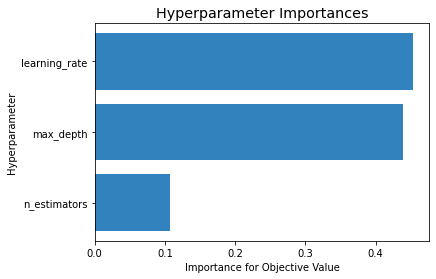

In [14]:
# Посмотрим на важность гиперпараметров
plot_param_importances(study);
plt.show();

**Резюме**

Благодаря подбору гиперпараметров удалось снизить среднюю ошибку на объекте до 1704 евро (на 5-fold кросс-валидации)  
Наиболее важные гиперпараметры, которые влияют на качество работы алгоритма - темп обучения и максимальная глубина деревьев.

### Подбор гиперпараметров для случайного леса

На данном этапе подберем гиперпараметры для алгоритма случайного леса с использование библиотеки `optuna`.

Будем подирать следующие гиперпараметры:  
- `n_estimators`: количество деревьев в ансамбле,
- `max_features`: максимально количество признаков, используемое для поиска наилучшего разбиения в узле,
- `min_samples_leaf` - минимальное количество экземпляров, которое должно быть в левом и правом листе для того, чтобы совершить разбиение.

In [9]:
# Создадим функцию "objective", которую будем минимизировать
def objective(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 7),
        "random_state": 777
    }
    
    # Инициализируем модель
    rf = RandomForestRegressor(**params)
    ct = ColumnTransformer(
        [
        ('fil_encode_pipe', Pipeline([('filler', SimpleImputer(strategy='constant', fill_value='unknown')), 
                                      ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=888))]), cat_columns)
        ], remainder='passthrough'
    )
    
    rf_pipe = Pipeline(
        [
            ('fill_encode', ct), 
            ('estimator', rf)
        ]
    )
    
    # Получим результаты на 5-fold кросс-валидации
    scores = cross_val_score(
        rf_pipe, X, y, error_score='raise', scoring='neg_root_mean_squared_error'
    )
    
    # Вычислим среденее RMSE
    rmse = -scores.mean()

    return rmse

In [10]:
%%time

# Создадим объект 'study', которые будет заниматься минимизацией функции 'objective'
study = optuna.create_study(direction="minimize", study_name='Random Forest Tuning Hyperparameters')

# Обернем 'objective' внутрь lambda-фнукции, чтобы передать ей доп параметры
func = lambda trial: objective(trial, train_X, train_y)

# Запустим процесс оптимизации с количеством итераций равным 30-и
study.optimize(func, n_trials=30, show_progress_bar=True)

[I 2022-05-19 18:39:38,621] A new study created in memory with name: Random Forest Tuning Hyperparameters


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-05-19 18:57:30,667] Trial 0 finished with value: 1766.2998523100937 and parameters: {'n_estimators': 1000, 'max_features': 'log2', 'min_samples_leaf': 4}. Best is trial 0 with value: 1766.2998523100937.
[I 2022-05-19 18:59:16,701] Trial 1 finished with value: 1784.9708043577562 and parameters: {'n_estimators': 100, 'max_features': 'log2', 'min_samples_leaf': 5}. Best is trial 0 with value: 1766.2998523100937.
[I 2022-05-19 19:12:09,311] Trial 2 finished with value: 1802.6686514136713 and parameters: {'n_estimators': 800, 'max_features': 'log2', 'min_samples_leaf': 7}. Best is trial 0 with value: 1766.2998523100937.
[I 2022-05-19 19:23:54,687] Trial 3 finished with value: 1766.6356358695273 and parameters: {'n_estimators': 700, 'max_features': 'log2', 'min_samples_leaf': 4}. Best is trial 0 with value: 1766.2998523100937.
[I 2022-05-19 19:30:55,534] Trial 4 finished with value: 1767.2737225222263 and parameters: {'n_estimators': 400, 'max_features': 'log2', 'min_samples_leaf': 4

In [11]:
# Сохраним объект 'study' для более быстрого доступа к нему
with open('car_price_rf_study.pkl', "wb") as f:
    pickle.dump(study, f)

In [12]:
# Выведем результаты подбора гиперпараметров на экран
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 1751.50317
	Best params:
		n_estimators: 1000
		max_features: sqrt
		min_samples_leaf: 3


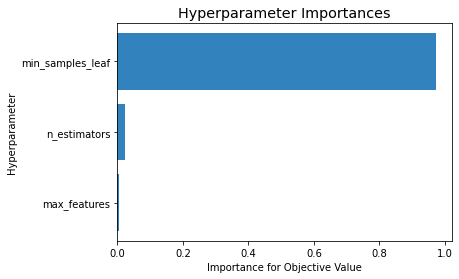

In [13]:
# Посмотрим на важность оптимизируемых гиперпараметров
plot_param_importances(study);
plt.show();

**Резюме**

Благодаря подбору гиперпараметров удалось снизить среднюю ошибку c 1763.3 до 1751.5 евро (на 5-fold кросс-валидации)  
Наиболее важный гиперпараметр, который влияет на качество работы алгоритма - минимальное количество объектах в правом и левом листе, необходимо для того, чтобы разбиение произошло.

## Оценка результатов на тестовых данных

### Оцениваем градиентный бустинг

Зададим модели градиентного бустинга подобранные гиперпараметры и обучим на всей тренировочной выборке с использованием валидационного сета данных при обучении.

Так как мы будем отслеживать переобучение на валидационной выборке, выставим чуть большее количество деревьев.

In [16]:
# Инициализируем модель с подобранными гиперпараметрами.
best_params = {'n_estimators': 2000,
               'learning_rate': 0.11297666496031618,
               'max_depth': 9, 
               'random_state': 777}
lgbm_final = LGBMRegressor(**best_params)

# Разделим выборку на обучющую и валидационную, на которой мы будем отслеживать переобучение.
train_fit_X, eval_X, train_fit_y, eval_y = train_test_split(
    train_X, train_y, test_size=0.2, random_state=777
)

lgbm_final.fit(
    train_fit_X, train_fit_y, 
    categorical_feature=cat_columns, eval_metric='rmse', 
    early_stopping_rounds=100, eval_set=(eval_X, eval_y)
)

[1]	valid_0's rmse: 4160.21	valid_0's l2: 1.73074e+07
[2]	valid_0's rmse: 3855.15	valid_0's l2: 1.48622e+07
[3]	valid_0's rmse: 3595.73	valid_0's l2: 1.29293e+07
[4]	valid_0's rmse: 3366.75	valid_0's l2: 1.1335e+07
[5]	valid_0's rmse: 3171.76	valid_0's l2: 1.00601e+07
[6]	valid_0's rmse: 3002.49	valid_0's l2: 9.01495e+06
[7]	valid_0's rmse: 2855.79	valid_0's l2: 8.15551e+06
[8]	valid_0's rmse: 2723.24	valid_0's l2: 7.41606e+06
[9]	valid_0's rmse: 2608.43	valid_0's l2: 6.80392e+06
[10]	valid_0's rmse: 2513.01	valid_0's l2: 6.31524e+06
[11]	valid_0's rmse: 2425.71	valid_0's l2: 5.88406e+06
[12]	valid_0's rmse: 2353.74	valid_0's l2: 5.54009e+06
[13]	valid_0's rmse: 2289.58	valid_0's l2: 5.24219e+06
[14]	valid_0's rmse: 2237.84	valid_0's l2: 5.00795e+06
[15]	valid_0's rmse: 2190.89	valid_0's l2: 4.80001e+06
[16]	valid_0's rmse: 2150.37	valid_0's l2: 4.62411e+06
[17]	valid_0's rmse: 2113.09	valid_0's l2: 4.46516e+06
[18]	valid_0's rmse: 2082.42	valid_0's l2: 4.33648e+06
[19]	valid_0's rmse:

LGBMRegressor(learning_rate=0.11297666496031618, max_depth=9, n_estimators=2000,
              random_state=777)

In [17]:
# Сделаем предсказания на тестовой выборке, посчитаем RMSE и выведем его на экран
test_pred = lgbm_final.predict(test_X)
score = mean_squared_error(test_y, test_pred, squared=False)

print(f'RMSE финальной модели на тестовых данных: {score}')

RMSE финальной модели на тестовых данных: 1685.3592461481162


In [23]:
# Добавим результат в таблицу
fit_params = {'categorical_feature': cat_columns, 'eval_metric': 'rmse', 
              'early_stopping_rounds': 100, 'eval_set': (eval_X, eval_y), 'verbose': False}
    
results_table['LightGBM Tuned (test_score)'] = [round(score, 2), 
                                                estimate_time(lgbm_final, 'fit', train_fit_X, train_fit_y, fit_params=fit_params), 
                                                estimate_time(lgbm_final, 'predict', train_X.iloc[0:0+1])]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN
LinearRegression,3141.18,4.63,0.00
RandomForest,1784.97,26.65,0.01
LightGBM,1794.51,7.00,0.01
LightGBM Tuned (test_score),1685.36,442.98,0.01


Посмотрим на важность признаков.

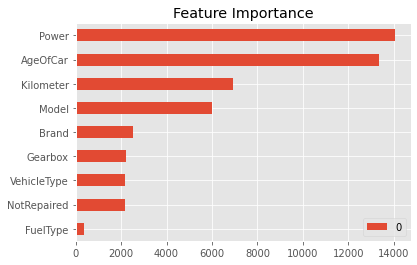

In [24]:
pd.DataFrame(lgbm_final.feature_importances_, index=lgbm_final.feature_name_).sort_values(by=0).plot.barh(grid=True, title='Feature Importance');

**Резюме**

RMSE финальной модели на тестовых данных составляет 1685.36 евро. Скорость обучения - 442.98 секунды. Скорость предсказания на 1-м объектe - 0.01 секунда.  
Наиболее важными признаками, которые влияют на стоимость модель посчитала мощность автомобиля и его возраст.

### Оцениваем случайный лес

In [10]:
%%time

# Инициализируем модель с подобранными гиперпараметрами.
rf = RandomForestRegressor(
    n_estimators=1000, max_features='sqrt', min_samples_leaf=3, random_state=777
)
ct = ColumnTransformer(
    [('fil_encode_pipe', Pipeline(
        [
            ('filler', SimpleImputer(strategy='constant', fill_value='unknown')), 
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=888))
        ]
                                  ), cat_columns)
    ], remainder='passthrough'
)
rf_pipe_final = Pipeline(
    [
        ('fill_encode', ct), 
        ('estimator', rf)
    ]
)

# Обучим модель на всей тренировочной выборке
rf_pipe_final.fit(train_X, train_y)

CPU times: user 5min 5s, sys: 5.6 s, total: 5min 11s
Wall time: 5min 12s


Pipeline(steps=[('fill_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fil_encode_pipe',
                                                  Pipeline(steps=[('filler',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=888))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('estimat

In [12]:
%%time

# Измерим время на предсказание 1-го объекта
rf_pipe_final.predict(train_X.iloc[0:0+1])

CPU times: user 100 ms, sys: 4 µs, total: 100 ms
Wall time: 98.2 ms


array([8239.8616862])

In [13]:
# Сделаем предсказания на тестовой выборке, посчитаем RMSE и выведем его на экран
test_pred = rf_pipe_final.predict(test_X)
score = mean_squared_error(test_y, test_pred, squared=False)

print(f'RMSE финальной модели случайного леса на тестовых данных: {score}')

RMSE финальной модели случайного леса на тестовых данных: 1726.8885988331042


In [15]:
# Добавим результат в таблицу
# Здесь мы введем показатели вручную, так как оперативная память перегружается при попытке вычислить их через функцию
results_table['Random Forest Tuned (test_score)'] = [1726.89, 312, 0.1]

results_table.T

,"RMSE, eur","Fit time, sec","Predict time, sec"
Dummy,4515.36,NaN,NaN
LinearRegression,3141.18,4.63,0.00
RandomForest,1784.97,26.65,0.01
LightGBM,1794.51,7.00,0.01
LightGBM Tuned (test_score),1685.36,442.98,0.01
Random Forest Tuned (test_score),1726.89,312.00,0.10


Посмотрим на важность признаков.

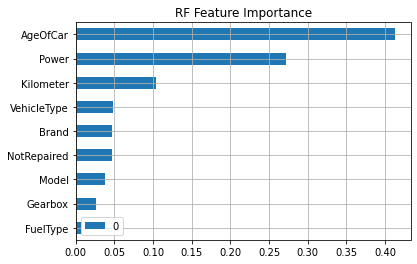

In [17]:
(
    pd.DataFrame(rf_pipe_final['estimator'].feature_importances_, index=cat_columns+num_columns)
    .sort_values(by=0)
    .plot.barh(grid=True, title='RF Feature Importance')
);

**Резюме**

RMSE финальной модели на тестовых данных составляет 1727 евро. Скорость обучения - 312 секунд.   Скорость предсказания на 1-м объектe - 0.1 секунды.  
Наиболее важными признаками, которые влияют на стоимость модель посчитала возраст и мощность автомобиля.

## Интерпретация модели

Посмотрим на вклад признаков с использованием библиотеки `shap`.

In [4]:
explainer = shap.TreeExplainer(lgbm_final)
shap_values = explainer.shap_values(train_X)

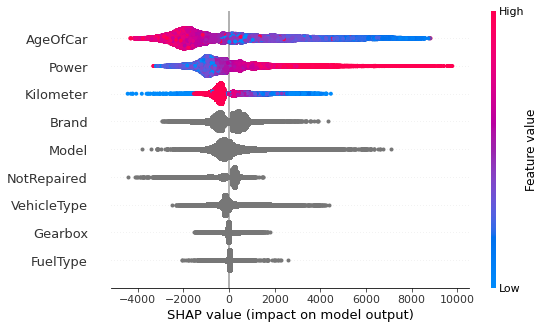

In [5]:
shap.summary_plot(shap_values, train_X)

Исходя из графика, можно предположить, что:  
- Чем больше возраст авто - тем ниже его стоимость.
- Чем больше мощность автомобиля - тем выше его стоимость.
- В общем случае, чем выше пробег у авто, тем ниже его стоимость. Однако есть ряд авто, которые имеют малый пробег, и при этом их цена сильно ниже, чем у авто с высоким пробегом.

## Вывод

В ходе работы были проделаны следующие шаги:  
- Был проведен краткий исследователский анализ
- На этапе предобработки, данные были  созданы новые признаки, а также был   

Целью данного проекта было подобрать модель, которая бы предсказывала цену на автомобили наиболее быстро и точно.  
В ходе решения задачи были проделаны следующие шаги:  
- На этапе исследовательского анализа было изучено влияние каждого признака на целевой показатель.  
- На этапе предобработки данных был выбран наиболее оптимальный способ работы с аномальными значениями, способ заполнения пропусков, а также были удалены лишние признаки и добавлены новые.  
- На этапе проверки моделей была изучена работа 3-х алгоритмов: линейной регрессии, случайного леса и градиентного бустинга. Были получены следущие результаты:  

|                  |   RMSE, eur |   Fit time, sec |   Predict time, sec |
|:-----------------|------------:|----------------:|--------------------:|
| Dummy            |     4515.36 |          nan    |              nan    |
| LinearRegression |     3141.18 |            4.63 |                0    |
| RandomForest     |     1784.97 |           26.65 |                0.01 |
| LightGBM         |     1794.51 |            7    |                0.01 |  

- На следующем этапе мы подобрали наиболее оптимальные гипрепараметры для градиентного бустинга и случайного леса с использованием библиотеки `optuna`.  
- Финально, была произведена проверка качества работы моделей с оптимизированными гиперпараметрами на контрольной выборке. Были получены следующие результаты:  

|                  |   RMSE, eur |   Fit time, sec |   Predict time, sec |
|:-----------------|------------:|----------------:|--------------------:|
| LightGBM Tuned (test_score)  | 1685.36 | 442.98 | 0.01 |
| Random Forest Tuned (test_score)|1726.89|312.00|0.10 |

Наиболее высокое качество предсказания на тестовой выборке показал алгоритм градиентного бустинга: его СКО составляет 1685 евро, а скорость предсказания - 0.01 секунды.   

Также, была произведены интерпретация вклада признаков в предсказания модели с использованием shap values. На основании анализа, удалось выявить, что:
- Чем больше возраст авто - тем ниже его стоимость.
- Чем больше мощность автомобиля - тем выше его стоимость.
- В общем случае, чем выше пробег у авто, тем ниже его стоимость. Однако есть ряд авто, которые имеют малый пробег, и при этом их цена сильно ниже, чем у авто с высоким пробегом.



**Резюме**  
Для приложения рекомендуется использовать модель градиентного бустинга из библитеки lgbm с гипрепараметрами:  
- n_estimators: 1663 (это оптимальное количество деревьев при обучении, после которого качество на валидационной выборке в последующие 100 итераций перестает улучшаться)
- max_features: sqrt
- min_samples_leaf: 3  

В качестве признаков, которые необходимо подавать на вход, рекомендуется взять:  
- VehicleType - тип кузова (категориальный)
- Gearbox - тип коробки передач (категориальный)
- Brand - марка авто (категориальный)
- Model - модель авто (категориальный)
- FuelType - тип топлива (категориальный)
- NotRepaired - было ли авто в ремонте (категориальный)
- Power - мощность авто (вещественный)             
- Kilometer - пробег (вещественный)         
- AgeOfCar - возраст авто (вещественный)  

Для категориальных признаков, а свою очередь рекомендуется задать конечную выборку ответов, для того, чтобы признаки подавались в модель в единой форме.

# На этом основная часть проекта закончена...

# Рубрика "Э-э-ксперименты"

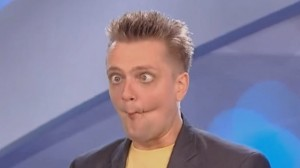

Для удобства, разместим в ячейке ниже весь необходимый код для подготовки данных и всех необходимых переменных.

In [13]:
### Загрузка данных ###

# Загрузим данные в переменную 'data' и посмотрим информацию.
data = pd.read_csv('/datasets/autos.csv')

### Предобработка данных ###

# Удалим дубликаты и лишние столбцы
data_pp = data.drop_duplicates().drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

# Удалим неявные дубликаты в столбце 'Model' и 'FuelType'
data_pp['Model'] = data_pp['Model'].mask(data_pp['Model'] == 'rangerover', other='range_rover')
data_pp['FuelType'] = data_pp['FuelType'].mask(data_pp['FuelType'] == 'petrol', other='gasoline')

# Создадим признак 'AgeOfCar' и сохраним туда разность года выгрузки (2016) и года регистрации авто
data_pp['AgeOfCar'] = 2016 - data_pp['RegistrationYear']

# Удалим признак 'RegistrationYear
data_pp = data_pp.drop('RegistrationYear', axis=1)

# Все значения возраста авто, которые меньше нуля либо больше 215 лет заменим на -10. Мы сделаем это и для тренировочного и для тестового датасета, чтобы объеденить нереалистичные значения возраста воедино.
data_pp['AgeOfCar'] = data_pp['AgeOfCar'].where(data_pp.AgeOfCar.isin(range(0, 215)), -10)

# Разделим на трейн и тест
train_data_raw, test_data_raw = train_test_split(data_pp, test_size=0.2, shuffle=True, random_state=777)
train_data, test_data = train_test_split(data_pp, test_size=0.2, shuffle=True, random_state=777)

# Сохраним названия и индексы категориальных столбцов в переменные 'cat_columns' и 'cat_columns_idx'
cat_columns = [
    col for col in train_data.drop('Price', axis=1).select_dtypes(include=['object']).columns
]
cat_columns_idx = [
    i for i, name in enumerate(train_data.drop('Price', axis=1).columns) 
    if name in train_data.drop('Price', axis=1).select_dtypes(include=['object'])
]
num_columns = [
    col for col in train_data.drop('Price', axis=1).select_dtypes(include=['integer', 'float']).columns
]
num_columns_idx = [
    i for i, name in enumerate(train_data.drop('Price', axis=1).columns) 
    if name in train_data.drop('Price', axis=1).select_dtypes(include=['integer', 'float'])
]
nan_columns = [
    col for col in train_data.drop('Price', axis=1).isna().sum()[train_data.drop('Price', axis=1).isna().sum() > 0].index
]

# Разделим тренировочные и тестовые данные на X и y
train_X, train_y = train_data_raw.drop('Price', axis=1), train_data_raw['Price']
test_X, test_y = test_data.drop('Price', axis=1), test_data['Price']

# Преобразуем столбцы формата 'object' в формат 'category', и числовые столбцы к минимально возможному формату 'integer'
train_X[cat_columns] = train_X[cat_columns].astype('category')
test_X[cat_columns] = test_X[cat_columns].astype('category')

for col in num_columns:
    train_X[col] = pd.to_numeric(train_X[col].astype('int'), downcast='integer')
    test_X[col] = pd.to_numeric(test_X[col], downcast='integer')

train_y = pd.to_numeric(train_y, downcast='integer')
test_y = pd.to_numeric(test_y, downcast='integer')

## Эксперимент №1

Гипотеза:  
Для автомобилей примерно одной ценовой категории предсказывать цену будет проще и СКО предсказаний будет меньше внутри ценовых групп. За счет этого удастся снизить общее СКО.

- Поделим целевой показатель на 6 бинов ("леблов")
- Предскажем для обучающей выборки эти лейблы с использованием функции 'cross_val_predict'
- Сгруппируем данные по предсказанным лейблам и для каждого лейбла-группы обучим отдельную модель
- На тестовых данных: предсказываем лейбл - для конкретного лейбла-группы применяем специально обученную модель, натасканную на предсказание именно этой группы.  

Либо:  
- Присоединяем вектор предсказанных лейблов к тренировочным данным и обучаем модель на новой выборке. 
- На тестовых данных: предсказываем лейбл, присоединяем, делаем предсказания.

In [14]:
# Создадим столбец с истинными категориями цены (диапазон цены из столбца "Price" будет разделен на 6 примерно равных бинов)
PriceLabel = pd.qcut(data_pp.Price, q=6, labels=[1, 2, 3, 4, 5, 6]).rename('PriceLabel')

# Отделим тренировочные ценовые лейблы от тестовых
train_y_label = PriceLabel[train_X.index]
test_y_label = PriceLabel[test_X.index]

In [5]:
lgbm_clf = LGBMClassifier(max_depth=5, random_state=777, objective='multiclass')

In [28]:
%%time

# Сохраним предсказания на кросс_валидации в переменной 'train_y_label_pred'
train_y_label_pred = cross_val_predict(
    lgbm_clf, train_X, train_y_label, 
    fit_params={'categorical_feature': cat_columns}
)

# Сохраним предсказания на кросс_валидации dummy-модели в переменной 'dummy_label_pred'
dummy_label_pred = cross_val_predict(
    DummyClassifier(strategy='stratified', random_state=777), train_X, train_y_label, 
)

CPU times: user 4min 20s, sys: 0 ns, total: 4min 20s
Wall time: 4min 26s


In [15]:
# Преобразуем предсказанные лейблы в pd.Series и сохраним для более быстрого доступа к ним.

# Созраняем в 'csv'
# train_y_label_pred = pd.Series(train_y_label_pred, index=train_X.index).rename('train_y_label_pred')
# train_y_label_pred.to_csv('car_price_train_y_label_pred.csv')

# Подгруджаем из 'csv'
train_y_label_pred = pd.read_csv('car_price_train_y_label_pred.csv', index_col=0)
train_y_label_pred = pd.Series(train_y_label_pred.T.values[0], index=train_X.index).rename('train_y_label_pred')

Посмотрим на качество предсказанных лейблов.

In [30]:
print(f'Качество мультиклассовой классификации (weighted): F1 = {f1_score(train_y_label, train_y_label_pred, average="weighted")}')
print(f'Качество мультиклассовой классификации dummy алгоритма (weighted): F1 = {f1_score(train_y_label, dummy_label_pred, average="weighted")}')

Качество мультиклассовой классификации (weighted): F1 = 0.6127288959106323
Качество мультиклассовой классификации dummy алгоритма (weighted): F1 = 0.16602877016477505


Неплохое качество. Можем использовать предсказанные лейблы для дальнейшей работы.

### Делим данные на шесть групп по цене -> для каждой группы обучаем модель -> внутри каждой группы проверяем качество на кросс-валидации.

In [1]:
def estimate_six_models_on_cv(train_data, train_target, predicted_labels, collection_of_models, fit_params={}):
    # Создадим табличку для сохранения результатов
    table_with_results = pd.DataFrame(index=['mean_rmse', 'dummy_rmse', 'training_sample_size', 'mean_price_in_group'])

    # В цикле, возмём каждую группу от 1 до 6, и проверим качество предсказания цены внутри этой группы.
    for num_group in tqdm(range(1, 7)):

        # Фильтруем объекты одной группы
        train_X_group = train_data[predicted_labels == num_group]
        train_y_group = train_target[predicted_labels == num_group]

        # Инициализируем модель
        lgbm_regr = collection_of_models[num_group]
        
        # Получаем rmse на 5-fold кросс-валидации
        scores = cross_val_score(
            lgbm_regr, train_X_group, train_y_group, 
            scoring='neg_root_mean_squared_error', error_score="raise", fit_params=fit_params
        )

        # Получаем rmse на 5-fold кросс-валидации для константной модели 
        dummy_scores = cross_val_score(
                DummyRegressor(), train_X_group, train_y_group, 
                scoring='neg_root_mean_squared_error' ,error_score="raise"
            )

        # Сохраняем результаты в переменные
        mean_score = -scores.mean() # Среднее RMSE
        mean_dummy_score = -dummy_scores.mean() # Среднее RMSE константной модели
        samples_in_X = train_X_group.shape[0] # Количество объектов в выборке внутри группы
        mean_target = train_y_group.mean() # Среднее значение целевого показателя внутри группы.

        # Добавляем показатели в табличку
        table_with_results[num_group] = [mean_score, mean_dummy_score, samples_in_X, mean_target]
        
    return table_with_results

In [44]:
default_regressors = {i: LGBMRegressor(random_state=777) for i in range(1, 7)}
cat_res_tab = estimate_six_models_on_cv(train_X, train_y, train_y_label_pred, 
                                        default_regressors, fit_params={'categorical_feature': cat_columns}
                                       )

# Сохраняем табличку в 'csv'
cat_res_tab.to_csv('car_price_cat_res_tab.csv')

display(cat_res_tab.T)
print('Mean RMSE', cat_res_tab.T['mean_rmse'].mean())

100%|██████████| 6/6 [03:30<00:00, 35.06s/it]


,mean_rmse,dummy_rmse,training_sample_size,mean_price_in_group
1,1185.844411,1348.064545,52485.0,884.480175
2,919.219054,1007.472507,50901.0,1350.645567
3,1114.005036,1210.536395,38024.0,2217.027167
4,1518.637965,1696.540126,45388.0,3626.811404
5,1953.843807,2309.637667,48803.0,6294.467943
6,2964.946731,4124.455442,47891.0,12136.070055


Mean RMSE 1609.416167138734


Пусть не очень сильно, но качество в каждой из групп лучше, чем качество константного алгоритма.  
Средняя ошибка по всем группам значительно меньше, чем ошибка, которую мы получили на кросс-валидации на этапе проверки моделей (1792 евро)

Посмотрим также как справится с задачей случайный лес.

In [70]:
# Инициализируем модель
rf = RandomForestRegressor(min_samples_leaf=5, max_features='sqrt', random_state=777)
ct = ColumnTransformer(
    [
        ('fil_encode_pipe', Pipeline([
                                      ('filler', SimpleImputer(strategy='constant', fill_value='unknown')), 
                                      ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=888))
                                     ]), cat_columns
        )
    ], remainder='passthrough'
)
rf_pipe = Pipeline(
    [('fill_encode', ct), ('estimator', rf)]
)

default_regressors = {i: clone(rf_pipe) for i in range(1, 7)}
cat_res_tab_rf_estimators = estimate_six_models_on_cv(train_X, train_y, train_y_label_pred, default_regressors)

# Сохраняем табличку в 'csv'
cat_res_tab_rf_estimators.to_csv('car_price_cat_res_tab_rf_estimators.csv')

display(cat_res_tab_rf_estimators.T)
print('Mean RMSE (random forests)', cat_res_tab_rf_estimators.T['mean_rmse'].mean())

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


,mean_rmse,dummy_rmse,training_sample_size,mean_price_in_group
1,1202.461576,1348.064545,52485.0,884.480175
2,919.281142,1007.472507,50901.0,1350.645567
3,1115.600877,1210.536395,38024.0,2217.027167
4,1529.303730,1696.540126,45388.0,3626.811404
5,1973.375654,2309.637667,48803.0,6294.467943
6,2965.790087,4124.455442,47891.0,12136.070055


Mean RMSE (random forests) 1617.6355109066017


Модель градиентного бустинга показала незначительно более высокое качество предсказания на всех группах. В дальнейшем будем использовать ее.

Кончено, наиболее правильно было бы для каждой группы обучать модель на выборке, полученной на основании истинного таргета, а потом делать предсказания для выборки, полученной на основании предсказанного таргета. Но тогда одни и те же объекты могли попасть в трейн и в тест, из-за чего мы могли бы получить переобучение и наблюдать завшенно-оптимистичные результаты.

На следующем этапе подберем гиперпараметры.

### Подбор гиперпараметров.

На данном этапе подберем гиперпараметры для 7-и моделей:  
- Первая модель будет предсказывать "ценовую категорию" (от 1 до 6). Будем решать задачу мультиклассовой классификации.
- Оставшиеся 6 моделей будут обучены только на объектах одной из шести категорий и будут предсказывать конечную стоимость авто.  
 
Для подбора гиперпараметров воспользуемся библиотекой `hyperopt`.

#### Для модели классификации

Будем подбирать следующие гиперпараметры:  
- `max_depth` - максимальную глубину базовых алгоритмов.
- `n_estimators`: количество деревьев в ансамбле,
- `learning_rate`: темп обучения,
- `colsample_bytree`: количество признаков, на которых будет обучаться отдельный базовый алгориитм
- `subsample`: объем подвыборки (доля объектов), на которой будет обучаться отдельный базовый алгоритм.

In [ ]:
search_space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 13, 1)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 2100, 100)),
    'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.31, 0.005)), 
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.99, 0.1)),
    'subsample': hp.uniform('subsample', 0.8, 1)
}

def objective(params):
    lgbm_clf = LGBMClassifier(random_state=777, objective='multiclass')
    estimator = lgbm_clf.set_params(**params)

    score = cross_val_score(estimator, train_X, train_y_label, scoring='f1_weighted',
                            fit_params={'categorical_feature': cat_columns}
                           )

    score_final = -score.mean()

    # Возвращаем результаты, которые записываются в Trials()
    return {'loss': score_final, 'params': params, 'status': STATUS_OK}

In [15]:
def run_trials(n, objective, search_space, directory):
    for i in range(n):
        trials_step = 3  # how many additional trials to do after loading saved trials. 1 = save after iteration
        max_trials = 1 # initial max_trials. put something small to not have to wait

        try:  # try to load an already saved trials object, and increase the max
            trials = pickle.load(open(directory, "rb"))
            print("Found saved Trials! Loading...")
            max_trials = len(trials.trials) + trials_step
            print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
        except:  # create a new trials object and start searching
            trials = Trials()
            
        # Зададим псвевдослучайное состояние равное количеству итераций
        rand = max_trials
        
        # Запустим процесс оптимизации
        best = fmin( 
              # функция для оптимизации  
                fn=objective,
              # пространство поиска гиперпараметров  
                space=search_space,
              # алгоритм поиска
                algo=tpe.suggest,
              # число итераций 
                max_evals=max_trials,
              # куда сохранять историю поиска
                trials=trials,
              # random state
                rstate=np.random.default_rng(rand),
              # progressbar
                show_progressbar=True
            )
        # Напечатаем результаты
        print("Best:", best)
        print(trials.results[np.argmin([r['loss'] for r in trials.results])]['params'])

        # Сохраним объект 'trials'
        with open(directory, "wb") as f:
            pickle.dump(trials, f)

In [38]:
# Запустим процесс подбора гиперпараметров.
run_trials(10, objective, search_space, "car_price_exp1_trials.pkl")

In [32]:
# Загрузим объект Trials() и сохраним в переменную "trials"
trials = pickle.load(open("car_price_exp1_trials.pkl", "rb"))

# Сохраним наилучшие гиперпараметры модели в переменную "best_params"
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

# Выведем на экран лучшие гиперпараметры модели
print('Best hyperparameters for classifer:')
for name, hp in best_params.items():
    print(f'- {name}: {hp}') 

Best hyperparameters for classifer:
- colsample_bytree: 1.0000000000000002
- learning_rate: 0.11499999999999998
- max_depth: 11
- n_estimators: 1500
- subsample: 0.9919912855712281


**Получим новые предсказанные лейблы для тренировочной выборки с использованием оптимизированного классификатора**

In [35]:
%%time

lgbm_clf_tuned = LGBMClassifier(random_state=777, objective='multiclass')
lgbm_clf_tuned.set_params(**best_params).set_params(colsample_bytree=1)


# Сохраним предсказания на кросс_валидации в переменной 'train_y_label_pred_tuned'
train_y_label_pred_tuned = cross_val_predict(
    lgbm_clf_tuned, train_X, train_y_label, 
    fit_params={'categorical_feature': cat_columns}
)

CPU times: user 1h 28min 42s, sys: 34.6 s, total: 1h 29min 17s
Wall time: 1h 30min 13s


In [74]:
# Преобразуем предсказанные лейблы в pd.Series и сохраним для более быстрого доступа к ним.

# Созраняем в 'csv'
# train_y_label_pred_tuned = pd.Series(train_y_label_pred_tuned, index=train_X.index).rename('train_y_label_pred_tuned')
# train_y_label_pred_tuned.to_csv('car_price_train_y_label_pred_tuned.csv')

# Подгруджаем из 'csv'
train_y_label_pred_tuned = pd.read_csv('car_price_train_y_label_pred_tuned.csv', index_col=0)
train_y_label_pred_tuned = pd.Series(train_y_label_pred_tuned.T.values[0], index=train_X.index).rename('train_y_label_pred_tuned')

Посмотрим на качество предсказанных лейблов.

In [37]:
print(f'Качество мультиклассовой классификации до оптимизации гиперпараметров (weighted): F1 = {f1_score(train_y_label, train_y_label_pred, average="weighted")}')
print(f'Качество мультиклассовой классификации после оптимизации гиперпараметров (weighted): F1 = {f1_score(train_y_label, train_y_label_pred_tuned, average="weighted")}')

Качество мультиклассовой классификации до оптимизации гиперпараметров (weighted): F1 = 0.6127288959106323
Качество мультиклассовой классификации после оптимизации гиперпараметров (weighted): F1 = 0.6337867741894745


Посмотрим, улучшаться ли показатели базовых регрессоров на кросс-валидации, если мы поделим выборку по новым лейблам, которые были пресказаны более совершенным классификатором.

In [74]:
default_regressors = {i: LGBMRegressor(random_state=777) for i in range(1, 7)}
res = estimate_six_models_on_cv(train_X, train_y, train_y_label_pred_tuned, 
                                        default_regressors, fit_params={'categorical_feature': cat_columns}
                                       )

display(res.T)
print('Mean RMSE', res.T['mean_rmse'].mean())

100%|██████████| 6/6 [01:08<00:00, 11.47s/it]


,mean_rmse,dummy_rmse,training_sample_size,mean_price_in_group
1,1170.637886,1325.692760,50694.0,837.059790
2,865.568468,924.880894,48858.0,1296.975644
3,1135.597709,1212.061877,42203.0,2190.763571
4,1483.398952,1606.599964,46578.0,3639.766778
5,1971.656229,2264.312934,47917.0,6386.150239
6,2917.102576,4048.699561,47242.0,12249.396744


Mean RMSE 1590.6603034119296


In [77]:
# Результаты для выборки, которая была поделена классификатором без настройки гиперпараметров
display(cat_res_tab.T)
print('Mean RMSE', cat_res_tab.T['mean_rmse'].mean())

,mean_rmse,dummy_rmse,training_sample_size,mean_price_in_group
1,1185.844411,1348.064545,52485.0,884.480175
2,919.219054,1007.472507,50901.0,1350.645567
3,1114.005036,1210.536395,38024.0,2217.027167
4,1518.637965,1696.540126,45388.0,3626.811404
5,1953.843807,2309.637667,48803.0,6294.467943
6,2964.946731,4124.455442,47891.0,12136.070055


Mean RMSE 1609.416167138734


Видно, что улучшились результаты не только моделей, но и константного алгоритма. Скорее всего, это произошло вследствие того, что мы смогли более точно разделить выборку по ценовым группам.

#### Для моделей регрессии.

Здесь возможно 2 варианта:  
- Мы можем поделить выборку на группы, используя предсказанные лейблы, и для каждой ценовой группы обучить соотвествующую модель.  
- А можем использовать истинные лейблы при разделении выборки на группы. И затем для каждой группы, разделенной на основе истинных лейблов обучить модель. 

Иными словами, мы можем обучить модели на истинных группах, а можем на предсказанных группах.  
Думаю, все же следует делить выборку по истинному таргету. Так и поступим.

In [29]:
def find_hyperparams_for_regressor(num_group, num_trials, y_labels):
    
    trial_directory = f'car_price_exp1_trials_regr_{num_group}'
    
    train_X_group = train_X[y_labels == num_group]
    train_y_group = train_y[y_labels == num_group]
    
    
    search_space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 13, 1)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 2100, 500)),
    'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.31, 0.005))
    }
    
    def objective(params):
        lgbm_rgr = LGBMRegressor(random_state=777)
        estimator = lgbm_rgr.set_params(**params)

        score = cross_val_score(
            estimator, train_X_group, train_y_group, scoring='neg_root_mean_squared_error',
            fit_params={'categorical_feature': cat_columns}
        )
        score_final = -score.mean()

        # Возвращаем результаты, которые записываются в Trials()
        return {'loss': score_final, 'params': params, 'status': STATUS_OK}
    
    # Запускаем процесс подбора гиперпараметров.
    run_trials(num_trials, objective, search_space, trial_directory)
    
    trials = pickle.load(open(trial_directory, "rb"))
    
    # Сохраним наилучшие гиперпараметры модели в переменную "best_params"
    best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
    
    # Добавляем гиперпараметры в словарь
    return best_params

Запускаем процесс подбора гиперпараметров.

In [31]:
regressors_hyperparams_dict = dict()

for num_group in tqdm(range(1, 7)):
    best_params = find_hyperparams_for_regressor(num_group, 7, train_y_label)
    regressors_hyperparams_dict[num_group] = best_params

    with open('car_price_regressors_hyperparams_dict.pkl', "wb") as f:
        pickle.dump(regressors_hyperparams_dict, f)

  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 1/1 [1:32:55<00:00, 5575.76s/trial, best loss: 219.2055030538067]
Best: {'learning_rate': 24, 'max_depth': 5, 'n_estimators': 1}
{'learning_rate': 0.12999999999999998, 'max_depth': 8, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 1 trials to 4 (+3) trials

100%|██████████| 4/4 [03:09<00:00, 63.29s/trial, best loss: 217.8739744423696]
Best: {'learning_rate': 45, 'max_depth': 3, 'n_estimators': 0}
{'learning_rate': 0.235, 'max_depth': 6, 'n_estimators': 100}
Found saved Trials! Loading...
Rerunning from 4 trials to 7 (+3) trials

100%|██████████| 7/7 [03:46<00:00, 75.39s/trial, best loss: 217.20131700665019] 
Best: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 1}
{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 7 trials to 10 (+3) trials

100%|██████████| 10/10 [05:21<00:00, 107.33s/trial, best loss: 217.20131700665019]
Best: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 1}
{'l

 20%|██        | 1/5 [1:55:31<7:42:07, 6931.94s/it]


Best: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 1}
{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 600}

100%|██████████| 1/1 [00:41<00:00, 41.85s/trial, best loss: 310.6770649211854]
Best: {'learning_rate': 24, 'max_depth': 5, 'n_estimators': 1}
{'learning_rate': 0.12999999999999998, 'max_depth': 8, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 1 trials to 4 (+3) trials

100%|██████████| 4/4 [02:57<00:00, 59.07s/trial, best loss: 309.5192042162322]
Best: {'learning_rate': 45, 'max_depth': 3, 'n_estimators': 0}
{'learning_rate': 0.235, 'max_depth': 6, 'n_estimators': 100}
Found saved Trials! Loading...
Rerunning from 4 trials to 7 (+3) trials

100%|██████████| 7/7 [03:29<00:00, 69.72s/trial, best loss: 309.19779903380805]
Best: {'learning_rate': 12, 'max_depth': 3, 'n_estimators': 0}
{'learning_rate': 0.06999999999999999, 'max_depth': 6, 'n_estimators': 100}
Found saved Trials! Loading...
Rerunning from 7 trials to 10 (+3) trials

100%|████████

 40%|████      | 2/5 [2:18:12<3:02:43, 3654.57s/it]


Best: {'learning_rate': 5, 'max_depth': 4, 'n_estimators': 3}
{'learning_rate': 0.034999999999999996, 'max_depth': 7, 'n_estimators': 1600}

100%|██████████| 1/1 [00:41<00:00, 41.78s/trial, best loss: 502.35756678025047]
Best: {'learning_rate': 24, 'max_depth': 5, 'n_estimators': 1}
{'learning_rate': 0.12999999999999998, 'max_depth': 8, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 1 trials to 4 (+3) trials

100%|██████████| 4/4 [02:58<00:00, 59.47s/trial, best loss: 501.85996842270987]
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 4 trials to 7 (+3) trials

100%|██████████| 7/7 [02:50<00:00, 56.87s/trial, best loss: 501.85996842270987]
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 7 tri

 60%|██████    | 3/5 [2:42:23<1:28:16, 2648.46s/it]


Best: {'learning_rate': 5, 'max_depth': 4, 'n_estimators': 3}
{'learning_rate': 0.034999999999999996, 'max_depth': 7, 'n_estimators': 1600}

100%|██████████| 1/1 [00:41<00:00, 41.41s/trial, best loss: 879.3459520741828]
Best: {'learning_rate': 24, 'max_depth': 5, 'n_estimators': 1}
{'learning_rate': 0.12999999999999998, 'max_depth': 8, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 1 trials to 4 (+3) trials

100%|██████████| 4/4 [03:00<00:00, 60.09s/trial, best loss: 877.0046708630591]
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 4 trials to 7 (+3) trials

100%|██████████| 7/7 [03:59<00:00, 79.89s/trial, best loss: 877.0046708630591] 
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 7 trial

 80%|████████  | 4/5 [3:05:29<35:49, 2149.90s/it]  


Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}

100%|██████████| 1/1 [00:39<00:00, 39.63s/trial, best loss: 1943.9143553077945]
Best: {'learning_rate': 24, 'max_depth': 5, 'n_estimators': 1}
{'learning_rate': 0.12999999999999998, 'max_depth': 8, 'n_estimators': 600}
Found saved Trials! Loading...
Rerunning from 1 trials to 4 (+3) trials

100%|██████████| 4/4 [02:43<00:00, 54.43s/trial, best loss: 1936.8390409063286]
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 4 trials to 7 (+3) trials

100%|██████████| 7/7 [02:56<00:00, 58.68s/trial, best loss: 1936.8390409063286]
Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
Found saved Trials! Loading...
Rerunning from 7 tr

100%|██████████| 5/5 [3:26:56<00:00, 2483.37s/it]


Best: {'learning_rate': 11, 'max_depth': 8, 'n_estimators': 3}
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}


In [32]:
for num, params in regressors_hyperparams_dict.items():
    print(num)
    print(params)

1
{'learning_rate': 0.034999999999999996, 'max_depth': 12, 'n_estimators': 1100}
2
{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 600}
3
{'learning_rate': 0.034999999999999996, 'max_depth': 7, 'n_estimators': 1600}
4
{'learning_rate': 0.034999999999999996, 'max_depth': 7, 'n_estimators': 1600}
5
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}
6
{'learning_rate': 0.06499999999999999, 'max_depth': 11, 'n_estimators': 1600}


### Обучаем модели

In [41]:
# Создадим функцию, которая будет обучать 1 регрессор
def fit_regressor(num_group, y_labels, regressors_hyperparams_dict):
    train_X_group = train_X[y_labels == num_group]
    train_y_group = train_y[y_labels == num_group]
    
    regressor = LGBMRegressor(random_state=777)
    best_params = regressors_hyperparams_dict[num_group]
    regressor.set_params(**best_params)
    
    regressor.fit(train_X_group, train_y_group)
    
    return regressor

In [39]:
BEST_PARAMS = {'colsample_bytree': 1, 
               'learning_rate': 0.11499999999999998,
               'max_depth': 11,
               'n_estimators': 3000,
               'subsample': 0.9919912855712281}

lgbm_clf_tuned = LGBMClassifier(random_state=777, objective='multiclass')
lgbm_clf_tuned.set_params(**BEST_PARAMS)

train_fit_X, eval_X, train_fit_y, eval_y = train_test_split(train_X, train_y_label, test_size=0.2, random_state=777, stratify=train_y_label)


lgbm_clf_tuned.fit(
    train_fit_X, train_fit_y, 
    categorical_feature=cat_columns, eval_metric='multi_logloss', 
    early_stopping_rounds=100, eval_set=(eval_X, eval_y)
)

[1]	valid_0's multi_logloss: 1.63939
[2]	valid_0's multi_logloss: 1.5316
[3]	valid_0's multi_logloss: 1.44886
[4]	valid_0's multi_logloss: 1.38245
[5]	valid_0's multi_logloss: 1.32937
[6]	valid_0's multi_logloss: 1.2834
[7]	valid_0's multi_logloss: 1.24388
[8]	valid_0's multi_logloss: 1.21068
[9]	valid_0's multi_logloss: 1.18233
[10]	valid_0's multi_logloss: 1.15707
[11]	valid_0's multi_logloss: 1.13479
[12]	valid_0's multi_logloss: 1.11589
[13]	valid_0's multi_logloss: 1.09848
[14]	valid_0's multi_logloss: 1.08261
[15]	valid_0's multi_logloss: 1.06839
[16]	valid_0's multi_logloss: 1.05586
[17]	valid_0's multi_logloss: 1.04469
[18]	valid_0's multi_logloss: 1.03427
[19]	valid_0's multi_logloss: 1.02521
[20]	valid_0's multi_logloss: 1.01657
[21]	valid_0's multi_logloss: 1.00913
[22]	valid_0's multi_logloss: 1.00244
[23]	valid_0's multi_logloss: 0.996048
[24]	valid_0's multi_logloss: 0.990474
[25]	valid_0's multi_logloss: 0.984764
[26]	valid_0's multi_logloss: 0.979516
[27]	valid_0's mult

LGBMClassifier(colsample_bytree=1, learning_rate=0.11499999999999998,
               max_depth=11, n_estimators=3000, objective='multiclass',
               random_state=777, subsample=0.9919912855712281)

In [40]:
with open('car_price_fitted_clf.pkl', "wb") as f:
    pickle.dump(lgbm_clf_tuned, f)

In [42]:
regressors_hyperparams_dict = pickle.load(open('car_price_regressors_hyperparams_dict.pkl', "rb"))

In [45]:
# Обучим 6 регрессоров в цикле.
fitted_regressors = dict()

for num_group in range(1, 7):
    regressor = fit_regressor(num_group, train_y_label, regressors_hyperparams_dict)
    fitted_regressors[num_group] = regressor

In [46]:
with open('car_price_fitted_regressors_dict.pkl', "wb") as f:
    pickle.dump(fitted_regressors, f)

Обучим также модели в соответсвии с разбиением на предсказанные ценовые категории, а не на истинные.

In [75]:
# Обучим 6 регрессоров в цикле.
fitted_regressors_2 = dict()

for num_group in range(1, 7):
    regressor = fit_regressor(num_group, train_y_label_pred_tuned, regressors_hyperparams_dict)
    fitted_regressors_2[num_group] = regressor

In [76]:
with open('car_price_fitted_regressors_2_dict.pkl', "wb") as f:
    pickle.dump(fitted_regressors_2, f)

### Проверяем результаты на тестовой выборке

In [66]:
# Создадим функцию, которая будет делать предсказания в соответствии с заданным алгоритмом
def make_predictions(test_X, classifier, collection_of_models):
    predictions = pd.Series()
    # Предсказываем категории
    test_y_labels_pred = classifier.predict(test_X)
    
    # Для каждой группы в цикле предсказываем цену авто
    for num_group in tqdm(range(1, 7)):
        
        # Фильтруем объекты одной группы
        test_X_group = test_X[test_y_labels_pred == num_group]
        
        # Инициализируем модель
        regressor = collection_of_models[num_group]
        # Делаем предсказания
        group_predictions = regressor.predict(test_X_group)
        group_predictions = pd.Series(group_predictions, index=test_X_group.index)
        # Добавляем предсказания в общую табличку
        predictions = pd.concat([predictions, group_predictions])
    return predictions

In [68]:
# Создадим функцию, которая будет сортировать массивы с предсказаниями по индексам и считать RMSE
def rmse_for_unsorted_arrays(y_true, y_pred):
    y_true = y_true.sort_index()
    y_pred = y_pred.sort_index()
    return mean_squared_error(y_true, y_pred, squared=False)

In [67]:
# Делаем предсказания для тестового набора данных
test_pred = make_predictions(test_X, lgbm_clf_tuned, fitted_regressors)

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


In [69]:
# Смотрим RMSE
test_score = rmse_for_unsorted_arrays(test_y, test_pred)
print(test_score)

1859.9476158448667


Проверим также результаты для регрессоров, которые были обучены на выборке, разбитой по предсказанным ценовым категориям, а не по истинным.

In [77]:
# Делаем предсказания для тестового набора данных
test_pred_2 = make_predictions(test_X, lgbm_clf_tuned, fitted_regressors_2)

100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


In [78]:
# Смотрим RMSE
test_score_2 = rmse_for_unsorted_arrays(test_y, test_pred_2)
print(test_score_2)

1700.5282331047447


Во втором случае мы получили неплохой результат, но он все еще уступает результату, который мы получили с помощью одного алгоритма (rmse = 1685.36)

**Резюме**

Похоже, что данный способ не помог нам улучшить качество предсказания.

### Попробуем просто присоеденить полученным столбцы к тренировочному датасету.

In [17]:
# Подгруджаем из 'csv'
train_y_label_pred_tuned = pd.read_csv('car_price_train_y_label_pred_tuned.csv', index_col=0)
train_y_label_pred_tuned = pd.Series(train_y_label_pred_tuned.T.values[0], index=train_X.index).rename('train_y_label_pred_tuned')

# Присоединяем стобец 'train_y_label_pred_tuned' к 'train_X'
train_X_with_tuned_pred = train_X.merge(train_y_label_pred_tuned, left_index=True, right_index=True)

In [82]:
# Инициализируем дефолтную модельку
lgbm_regr_default = LGBMRegressor(random_state=777)

# Создаем вектор предсказаний на кросс-валидации
train_x_tuned_pred_added__y_pred = cross_val_predict(
    lgbm_regr_default, train_X_with_tuned_pred, train_y, 
    fit_params={'categorical_feature': cat_columns}
)

# Смотрим RMSE между истинной ценой и предсказанной.
mean_squared_error(train_y, train_x_tuned_pred_added__y_pred, squared=False)

1764.4930864428638

Это на 30 у.е. меньше, чем ошибка на кросс-валидации на нетронутном датасете (1794.5)

Посмотрим, какой результат покажет модель на новой выборке, если мы зададим ей старые гипрепараметры (которые были подобраны на обыкновенной выборке в основной части проекта).  
Напомним, что RMSE данной модели на обычной выборке составлял 1706 у.е.

**P.S.**  
С чем еще можно поэксперементировать: 
- Подобрать гиперпараметры для модели регрессии, обученной на выборке с доп-признаком: предсказанная категория
- Попробовать разное количеством ценовых категорий
- Подобрать гипрепараметры для регрессоров, обученных на группах, разделенных на основе предсказанных ценовых категорий. Но вряд ли это сильно изменит картину.